# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

In [4]:
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
# for checking if NaN replacement is done properly:
azdias_chk = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

In [5]:
azdias.shape

(891221, 85)

In [6]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [7]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [50]:
feat_info.attribute.unique()

array(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ',
       'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'ALTER_HH', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_

In [6]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [7]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [169]:
azdias.tail()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
891216,-1,3,2,5.0,1,4,2,5,4,4,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,-1,2,1,4.0,3,3,3,2,2,3,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,-1,2,2,4.0,2,4,2,5,4,3,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,-1,1,1,3.0,1,5,3,5,5,5,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0
891220,-1,4,1,1.0,4,2,5,2,1,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,4.0,5.0


In [42]:
azdias['AGER_TYP'].value_counts()

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64

In [9]:
azdias['ALTERSKATEGORIE_GROB'].value_counts()

3    358533
4    228510
2    158410
1    142887
9      2881
Name: ALTERSKATEGORIE_GROB, dtype: int64

In [8]:
azdias['FINANZ_HAUSBAUER'].value_counts()

3    235184
5    183918
2    171847
4    157168
1    143104
Name: FINANZ_HAUSBAUER, dtype: int64

In [6]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
feat_info[:10]

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [25]:
temp = feat_info[1:2]['missing_or_unknown']

In [32]:
type(temp)

pandas.core.series.Series

In [36]:
feat_info['missing_or_unknown'][:5]

0      [-1,0]
1    [-1,0,9]
2      [-1,0]
3         [0]
4        [-1]
Name: missing_or_unknown, dtype: object

In [170]:
feat_info.groupby('attribute').missing_or_unknown.unique()

attribute
AGER_TYP                   [[-1,0]]
ALTERSKATEGORIE_GROB     [[-1,0,9]]
ALTER_HH                      [[0]]
ANREDE_KZ                  [[-1,0]]
ANZ_HAUSHALTE_AKTIV           [[0]]
ANZ_HH_TITEL                   [[]]
ANZ_PERSONEN                   [[]]
ANZ_TITEL                      [[]]
ARBEIT                     [[-1,9]]
BALLRAUM                     [[-1]]
CAMEO_DEUG_2015            [[-1,X]]
CAMEO_DEU_2015               [[XX]]
CAMEO_INTL_2015           [[-1,XX]]
CJT_GESAMTTYP                 [[0]]
EWDICHTE                     [[-1]]
FINANZTYP                    [[-1]]
FINANZ_ANLEGER               [[-1]]
FINANZ_HAUSBAUER             [[-1]]
FINANZ_MINIMALIST            [[-1]]
FINANZ_SPARER                [[-1]]
FINANZ_UNAUFFAELLIGER        [[-1]]
FINANZ_VORSORGER             [[-1]]
GEBAEUDETYP                [[-1,0]]
GEBAEUDETYP_RASTER             [[]]
GEBURTSJAHR                   [[0]]
GFK_URLAUBERTYP                [[]]
GREEN_AVANTGARDE               [[]]
HEALTH_TYP        

In [171]:
azdias.CAMEO_DEU_2015.unique()

array([nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
       '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C', 'XX'], dtype=object)

In [172]:
azdias.CAMEO_INTL_2015.unique()

array([nan, '51', '24', '12', '43', '54', '22', '14', '13', '15', '33',
       '41', '34', '55', '25', '23', '31', '52', '35', '45', '44', '32',
       'XX'], dtype=object)

In [58]:
azdias.CAMEO_INTL_2015.dtype

dtype('O')

In [53]:
feat_info['missing_or_unknown'].head()

0      [-1,0]
1    [-1,0,9]
2      [-1,0]
3         [0]
4        [-1]
Name: missing_or_unknown, dtype: object

In [54]:
feat_info['missing_or_unknown'][0][0]

'['

0       [-1, 0]
1    [-1, 0, 9]
2       [-1, 0]
3           [0]
4          [-1]
Name: missing_or_unknown_list, dtype: object

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [ ]:
# Identify missing or unknown data values and convert them to NaNs.

In [91]:
# 1a. convert missing_or_unknown column into proper list values  - method 1

feat_info['missing_or_unknown_list'] = feat_info['missing_or_unknown'].apply(lambda x: x.strip('[').strip(']').split(','))
feat_info['missing_or_unknown_list'].head()

0       [-1, 0]
1    [-1, 0, 9]
2       [-1, 0]
3           [0]
4          [-1]
Name: missing_or_unknown_list, dtype: object

In [9]:
range(len(feat_info['missing_or_unknown']))

range(0, 85)

In [68]:
# 1b. convert missing_or_unknown column into proper list values - method 2 (same as method 1 above)

for i in range(len(feat_info['missing_or_unknown'])):
    feat_info['missing_or_unknown_list'][i] = feat_info['missing_or_unknown'][i].strip('[').strip(']').split(',')

feat_info['missing_or_unknown_list'].head()

0       [-1, 0]
1    [-1, 0, 9]
2       [-1, 0]
3           [0]
4          [-1]
Name: missing_or_unknown_list, dtype: object

In [239]:
feat_info['missing_or_unknown'].head()

0      [-1,0]
1    [-1,0,9]
2      [-1,0]
3         [0]
4        [-1]
Name: missing_or_unknown, dtype: object

In [15]:
feat_info['missing_or_unknown_list'][84]

['-1', '9']

In [89]:
# 2. extract column header for azdias

cols = azdias.columns
cols

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [87]:
# find out unique missing value code before applying integer transformation in step 3 below

feat_info['missing_or_unknown'].unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [92]:
# 3. for each column's missing_or_unknown codes appearing in azdias, replace them with NaN

for col in cols:
    missing_value = feat_info[feat_info['attribute'] == col]['missing_or_unknown_list'] 
    
    
    for i in range(len(missing_value.iloc[0])):
        if missing_value.iloc[0][i] in ['-1', '0', '9']:
            missing_value.iloc[0][i] = int(missing_value.iloc[0][i])
        
    azdias[col] = azdias[col].replace(missing_value.iloc[0], np.nan)

In [ ]:
# 4. check if missing value code is replaced with NaN properly

In [88]:
azdias_chk.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [89]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [ ]:
azdias[]

In [90]:
azdias_chk.ALTERSKATEGORIE_GROB.unique()

array([2, 1, 3, 4, 9])

In [91]:
azdias.ALTERSKATEGORIE_GROB.unique()

array([  2.,   1.,   3.,   4.,  nan])

In [92]:
azdias_chk.CAMEO_DEU_2015.unique()

array([nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
       '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C', 'XX'], dtype=object)

In [93]:
azdias.CAMEO_DEU_2015.unique()

array([nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
       '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C'], dtype=object)

In [94]:
azdias_chk.CAMEO_INTL_2015.unique()

array([nan, '51', '24', '12', '43', '54', '22', '14', '13', '15', '33',
       '41', '34', '55', '25', '23', '31', '52', '35', '45', '44', '32',
       'XX'], dtype=object)

In [93]:
azdias.CAMEO_INTL_2015.unique()

array([nan, '51', '24', '12', '43', '54', '22', '14', '13', '15', '33',
       '41', '34', '55', '25', '23', '31', '52', '35', '45', '44', '32'], dtype=object)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [17]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
Missing_value_dist = azdias.isnull().sum()/len(azdias)*100
Missing_value_dist

AGER_TYP                 76.955435
ALTERSKATEGORIE_GROB      0.323264
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT          

In [34]:
Missing_value_dist.index

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

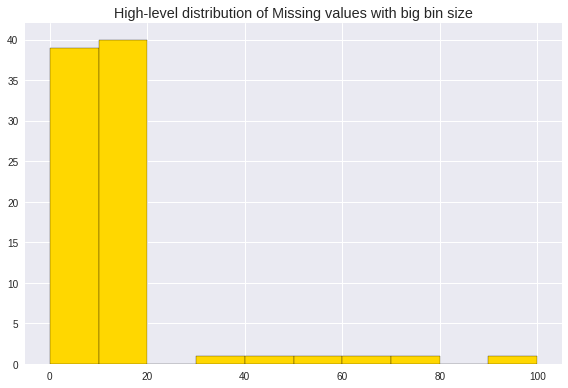

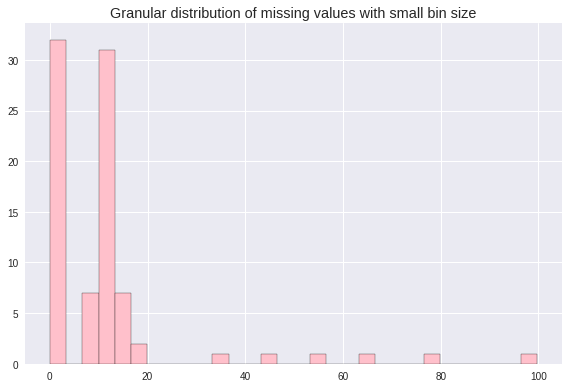

In [9]:
# Investigate patterns in the amount of missing data in each column.

bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


plt.style.use('seaborn')
plt.title('High-level distribution of Missing values with big bin size',fontsize='x-large')
plt.hist(Missing_value_dist, bins=bins, edgecolor='black', color='gold')
plt.tight_layout()
plt.show()

plt.title('Granular distribution of missing values with small bin size',fontsize='x-large')
plt.hist(Missing_value_dist, bins=30, edgecolor='black', color='pink')
plt.tight_layout()
plt.show()

In [18]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

#Let's identify columns with more than 20% of missing values
Cols_to_be_drop = Missing_value_dist[Missing_value_dist>20].index
# print("Columns to be dropped and their corresponding missing value proportion:", Cols_to_be_drop)
print("Columns to be dropped and their corresponding missing value proportion:", "\n", "\n", Missing_value_dist[Missing_value_dist>20])

azdias_keep = azdias.drop(Cols_to_be_drop, axis=1)

print("\n", "No. of columns before dropping:", azdias.columns.size)

print("\n", "No. of columns after dropping:", azdias_keep.columns.size)


Columns to be dropped and their corresponding missing value proportion: 
 
 AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64

 No. of columns before dropping: 85

 No. of columns after dropping: 79


In [124]:
azdias_keep.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [22]:
# check the data type of the 6 worst columns 
feat_info.loc[feat_info['attribute'].isin(Cols_to_be_drop)]

,attribute,information_level,type,missing_or_unknown,missing_or_unknown_list
0,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
11,GEBURTSJAHR,person,numeric,[0],[0]
40,TITEL_KZ,person,categorical,"[-1,0]","[-1, 0]"
43,ALTER_HH,household,interval,[0],[0]
47,KK_KUNDENTYP,household,categorical,[-1],[-1]
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]","[-1, 0]"


In [24]:
# check the data type of the 6 worst columns - same results as above method
feat_info[feat_info['attribute'].isin(Cols_to_be_drop)]

,attribute,information_level,type,missing_or_unknown,missing_or_unknown_list
0,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
11,GEBURTSJAHR,person,numeric,[0],[0]
40,TITEL_KZ,person,categorical,"[-1,0]","[-1, 0]"
43,ALTER_HH,household,interval,[0],[0]
47,KK_KUNDENTYP,household,categorical,[-1],[-1]
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]","[-1, 0]"


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

The majority of columns (i.e. 79 of them) have only 20% (or less) missing values across all rows.

Column TITEL_KZ is the worst column in terms of proportion of missing values (i.e. almost 100% missing).

The second-worst column in terms of proportion of missing values is AGER_TYP is (i.e. approaching 77%).

The cut-off threshold at 20% missing value (for removing columns) is, to be honest, a bit arbitrary, as people can always argue using a higher threshold. That said, if we look at the two histograms above, the cutoff at 20% is actually not a bad decision, as the majority of columns have only 20% (or less) missing values.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [19]:
# How much data is missing in each row of the dataset?

Missing_in_row = azdias.isnull().sum(axis=1)
Missing_in_row

0         49
1          4
2          4
3          9
4          3
5          2
6          5
7          4
8          4
9          3
10         3
11        53
12        10
13        11
14        53
15        11
16         9
17        53
18         9
19         5
20        16
21         6
22         6
23        11
24        53
25         9
26        24
27         5
28         4
29         4
          ..
891191     1
891192     4
891193     2
891194     2
891195     2
891196     2
891197     2
891198     4
891199     5
891200     5
891201     3
891202     5
891203    20
891204     2
891205     3
891206     3
891207     2
891208     6
891209     5
891210     4
891211     4
891212     4
891213     3
891214     4
891215     5
891216     6
891217     7
891218     9
891219     5
891220     6
Length: 891221, dtype: int64

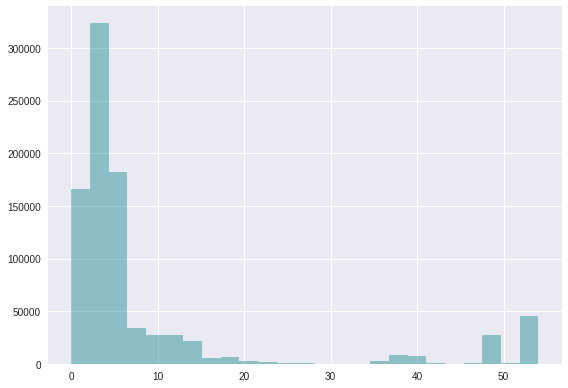

In [12]:
import seaborn as sns
# sns.countplot(data=Missing_in_row)
plt.style.use('seaborn')
# sns.distplot(Missing_in_row, kde=False, bins = 20, color='#444444')
sns.distplot(Missing_in_row, kde=False, bins = 25, color='teal')
plt.tight_layout()
plt.show()

In [20]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias_lt30m = azdias[azdias.isnull().sum(axis=1) < 30]  #less than 30 missing values in a row

azdias_mt30m = azdias[azdias.isnull().sum(axis=1) >= 30]  #equal to or more than 30 missing values in a row

In [44]:
print("Volume of subset with less than 30 missing values in a row:", len(azdias_lt30m) )

Volume of subset with less than 30 missing values in a row: 797929


In [45]:
print("Volume of subset with 30 or more missing values in a row:", len(azdias_mt30m) )

Volume of subset with 30 or more missing values in a row: 93292


In [46]:
len(azdias)

891221

In [25]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [23]:
azdias_lt30m.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [16]:
import math

def comparison_plot(col):
    plt.style.use('seaborn')

    fig, (ax1, ax2) = plt.subplots( nrows=1, ncols=2 )

    ax1.set( ylim=(0, int(azdias_lt30m.groupby(col)[col].count().max()*1.2) ) ) # ax1 and ax2 have the same axis scale
    ax2.set( ylim=(0, int(azdias_lt30m.groupby(col)[col].count().max()*1.2) ) ) # ax1 and ax2 have the same axis scale
    
    min_chk = azdias_mt30m[col].min() # check whether data does exist in dataset

    sns.countplot(data=azdias_lt30m, x=col, ax=ax1, color='turquoise')
    ax1.set_title('Less than 30 missing values in a row')
    
    if math.isnan(float(min_chk)) != 1:
        sns.countplot(data=azdias_mt30m, x=col, ax=ax2, color='salmon')
    ax2.set_title('30 or more missing values in a row')
    
    plt.tight_layout()
    plt.show()


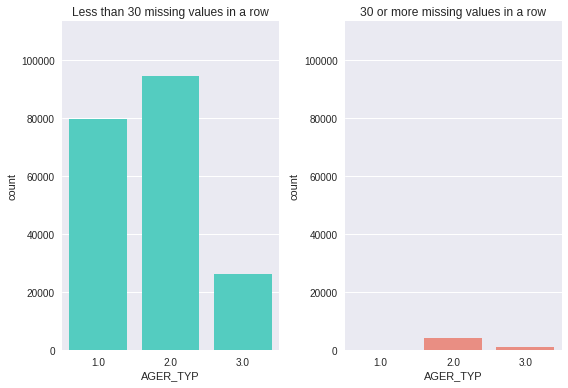

In [96]:
#one of the six worst columns
comparison_plot('AGER_TYP')

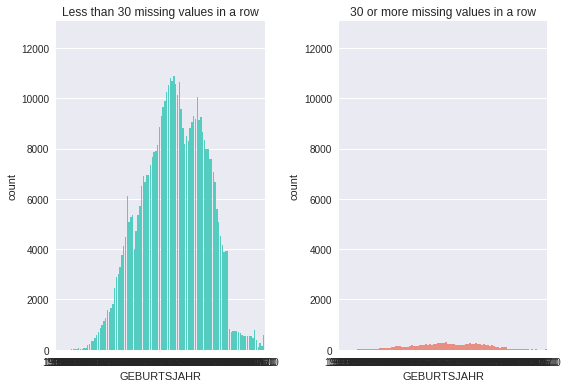

In [100]:
#one of the six worst columns
comparison_plot('GEBURTSJAHR')

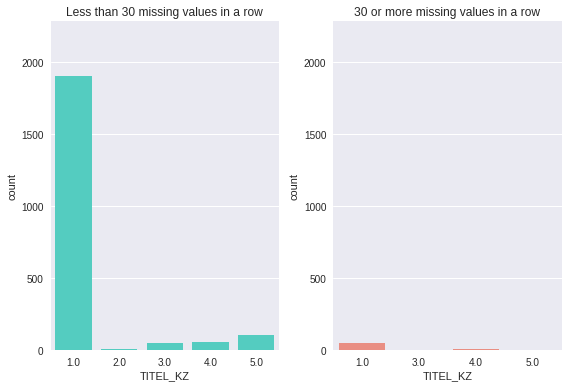

In [101]:
#one of the six worst columns
comparison_plot('TITEL_KZ')

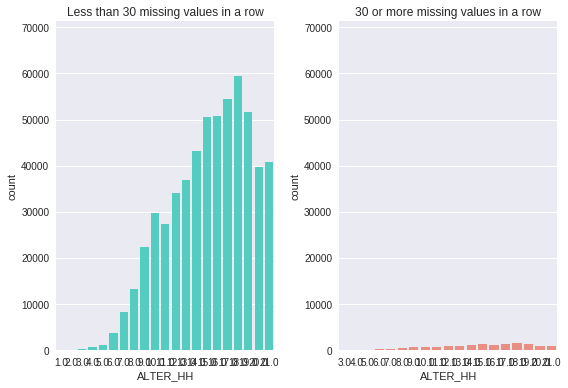

In [102]:
#one of the six worst columns
comparison_plot('ALTER_HH')

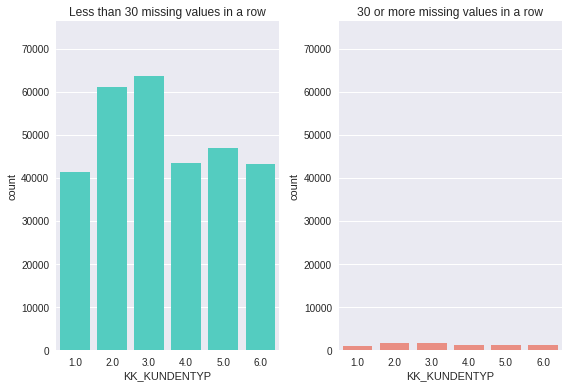

In [103]:
#one of the six worst columns
comparison_plot('KK_KUNDENTYP')

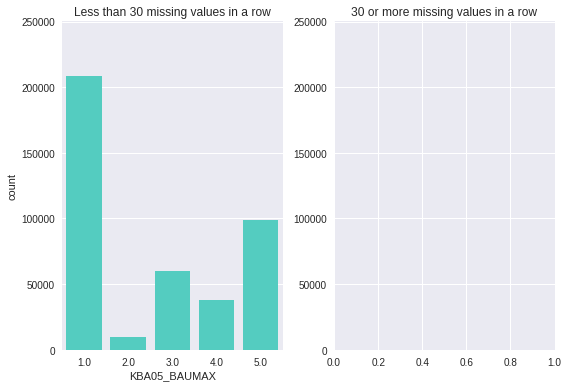

In [104]:
#one of the six worst columns
comparison_plot('KBA05_BAUMAX')

In [115]:
def comparison_plot_normal(col):
    plt.style.use('seaborn')

    fig, (ax1, ax2) = plt.subplots( nrows=1, ncols=2 )

    ax1.set( ylim=(0, int(azdias_lt30m.groupby(col)[col].count().max()*1.2) ) ) # ax1 and ax2 have the same axis scale
    ax2.set( ylim=(0, int(azdias_lt30m.groupby(col)[col].count().max()*1.2) ) ) # ax1 and ax2 have the same axis scale
    
    min_chk = azdias_mt30m[col].min() # check whether data does exist in dataset

    sns.countplot(data=azdias_lt30m, x=col, ax=ax1, color='blue')
    ax1.set_title('Less than 30 missing values in a row')
    
    if math.isnan(float(min_chk)) != 1:
        sns.countplot(data=azdias_mt30m, x=col, ax=ax2, color='orange')
    ax2.set_title('30 or more missing values in a row')
    
    plt.tight_layout()
    plt.show()


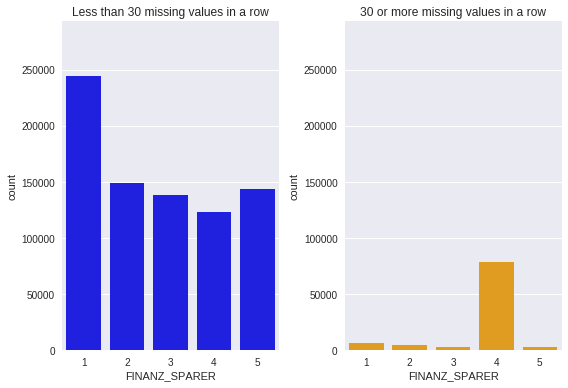

In [121]:
#column with no missing values
comparison_plot_normal('FINANZ_SPARER')

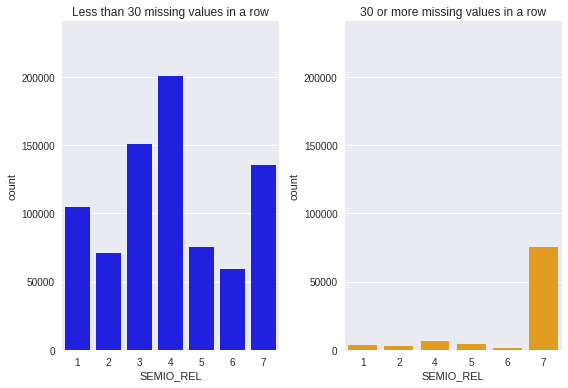

In [120]:
#column with no missing values
comparison_plot_normal('SEMIO_REL')

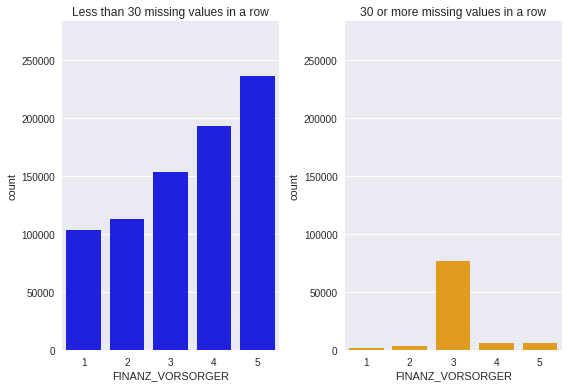

In [118]:
#column with no missing values
comparison_plot_normal('FINANZ_VORSORGER')

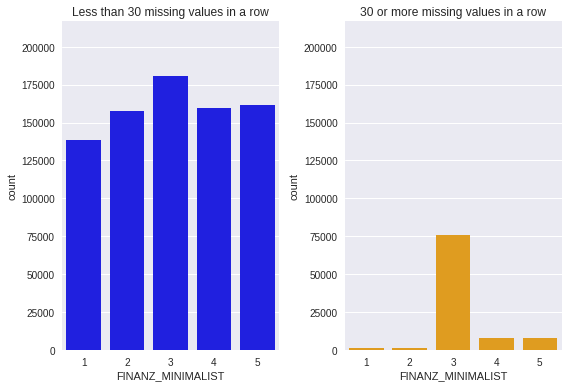

In [122]:
#column with no missing values
comparison_plot_normal('FINANZ_MINIMALIST')


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

As shown in the Seaborn distplot above, data can be roughly divided into two groups: 
- those with less than 30 missing values in a row
- thoes with 30 or more missing values in a row

The two groups are qualitatively very different from each other.
In line with what we would expect, when focusing on the 6 worst columns (e.g. AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, & KBA05_BAUMAX) in terms of their largest proportion of missing values within the column, the two groups are very different with no suprise. 

However, even when we look at the columns with no missing values, the two groups are still very different.

In other words, the group with less than 30 missing values in a row is intrinsically different from the group with 30 or more missing values in a row. 


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [54]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown,missing_or_unknown_list
0,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]


In [47]:
# How many features are there of each data type?

feat_info.groupby('type')['attribute'].count()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: attribute, dtype: int64

In [45]:
# same results as above method

feat_info.groupby('type')['attribute'].size()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: attribute, dtype: int64

In [ ]:
# check dtype of of numeric and interval

In [26]:
# | feat_info['type'] == 'numeric'

Numeric_col = feat_info[(feat_info['type'] == 'interval') | (feat_info['type'] == 'numeric') ]['attribute']
Numeric_col

azdias[Numeric_col].head()

,GEBURTSJAHR,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,MIN_GEBAEUDEJAHR,KBA13_ANZAHL_PKW
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1996.0,NaN,2.0,0.0,11.0,0.0,1992.0,963.0
2,1979.0,17.0,1.0,0.0,10.0,0.0,1992.0,712.0
3,1957.0,13.0,0.0,0.0,1.0,0.0,1997.0,596.0
4,1963.0,20.0,4.0,0.0,3.0,0.0,1992.0,435.0


In [33]:
for col in azdias[Numeric_col]:
    print(col, azdias[col].unique())

GEBURTSJAHR [   nan  1996.  1979.  1957.  1963.  1943.  1964.  1974.  1975.  1941.
  1993.  1946.  1988.  1991.  1966.  1949.  1982.  1972.  1990.  1985.
  1989.  1948.  1935.  1997.  1994.  1987.  2002.  1950.  1965.  1969.
  1978.  1958.  1944.  1967.  1977.  1960.  1970.  1973.  1971.  1937.
  1947.  1926.  1954.  1981.  1962.  1992.  2008.  1976.  1928.  1927.
  1968.  1940.  1952.  1961.  2006.  1938.  1945.  1942.  1984.  1930.
  1980.  1959.  1986.  1931.  1955.  1983.  2010.  1951.  1921.  1929.
  1939.  2001.  1995.  1956.  1953.  2012.  1934.  1913.  1914.  1922.
  2004.  1936.  2009.  1915.  2003.  2013.  1998.  2007.  1932.  2005.
  1923.  1925.  2015.  1933.  2017.  2000.  1999.  2014.  1920.  1918.
  1924.  2016.  2011.  1908.  1919.  1916.  1917.  1912.  1911.  1909.
  1910.  1904.  1906.  1905.  1900.  1907.  1902.]
ALTER_HH [ nan  17.  13.  20.  10.  14.  16.  21.  11.  19.  15.   9.  18.   8.   7.
  12.   4.   3.   6.   5.   2.   1.]
ANZ_PERSONEN [ nan   2.   1.   0. 

In [34]:
ordinal_col = feat_info[(feat_info['type'] == 'ordinal') ]['attribute']
ordinal_col

azdias[ordinal_col].head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,REGIOTYP,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,3,4,3,5,5,3,NaN,5.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1,5,2,5,4,5,3.0,1.0,5,...,3.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,1,4,1,2,3,5,3.0,3.0,4,...,2.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0
3,4.0,4,2,5,2,1,2,2.0,2.0,5,...,NaN,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0
4,3.0,4,3,4,1,3,2,3.0,5.0,6,...,5.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0


In [35]:
for col in azdias[ordinal_col]:
    print(col, azdias[col].unique())

ALTERSKATEGORIE_GROB [  2.   1.   3.   4.  nan]
FINANZ_MINIMALIST [3 1 4 2 5]
FINANZ_SPARER [4 5 2 3 1]
FINANZ_VORSORGER [3 2 1 5 4]
FINANZ_ANLEGER [5 2 1 4 3]
FINANZ_UNAUFFAELLIGER [5 4 3 1 2]
FINANZ_HAUSBAUER [3 5 2 4 1]
HEALTH_TYP [ nan   3.   2.   1.]
RETOURTYP_BK_S [  5.   1.   3.   2.   4.  nan]
SEMIO_SOZ [2 5 4 6 7 3 1]
SEMIO_FAM [6 4 1 5 7 2 3]
SEMIO_REL [7 4 3 2 5 1 6]
SEMIO_MAT [5 3 1 2 4 7 6]
SEMIO_VERT [1 4 7 2 6 5 3]
SEMIO_LUST [5 2 4 6 7 3 1]
SEMIO_ERL [3 2 6 7 4 5 1]
SEMIO_KULT [3 4 6 5 7 1 2]
SEMIO_RAT [4 6 3 2 7 5 1]
SEMIO_KRIT [7 4 3 1 5 6 2]
SEMIO_DOM [6 7 4 2 1 5 3]
SEMIO_KAEM [6 4 7 5 2 3 1]
SEMIO_PFLICHT [5 7 3 4 1 6 2]
SEMIO_TRADV [3 6 4 2 7 5 1]
HH_EINKOMMEN_SCORE [  2.   6.   4.   1.   5.   3.  nan]
W_KEIT_KIND_HH [ nan   3.   2.   6.   5.   4.   1.]
WOHNDAUER_2008 [ nan   9.   8.   3.   4.   5.   6.   2.   7.   1.]
KONSUMNAEHE [ nan   1.   5.   4.   3.   2.   6.   7.]
KBA05_ANTG1 [ nan   0.   1.   4.   2.   3.]
KBA05_ANTG2 [ nan   0.   3.   1.   4.   2.]
KBA05

In [ ]:
# features that has zero in their values - filling missing values with zero may not be an apropriate option
ANZ_TITEL ANZ_HH_TITEL ONLINE_AFFINITAET PLZ8_ANTG1 PLZ8_ANTG2

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [21]:
# identify all categorical columns

Category_col_temp = feat_info[feat_info['type'] == 'categorical']['attribute']
Category_col_temp

0             AGER_TYP
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
40            TITEL_KZ
41            VERS_TYP
42            ZABEOTYP
47        KK_KUNDENTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [22]:
# Exclude the six worst columns (decided in earlier steps)
Category_col_keep = []

for column in Category_col_temp:
    if column not in Cols_to_be_drop:
        Category_col_keep.append(column)

Category_col_keep

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [50]:
# Exclude the six worst columns (decided in earlier steps) - method 2
Category_col_keep2 = Category_col_temp[~Category_col_temp.isin(Cols_to_be_drop)]
Category_col_keep2

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [35]:
len(Category_col_keep2)

18

In [26]:
len(Category_col_keep)

18

In [16]:
print(len(Category_col_temp))

21


In [17]:
print(len(Category_col_keep))

18


In [23]:
# closer look at the values that each categorical column takes

for feature in Category_col_keep:
    print(feature, azdias_keep[feature].unique(), len(azdias_keep[feature].unique()))

ANREDE_KZ [1 2] 2
CJT_GESAMTTYP [  2.   5.   3.   4.   1.   6.  nan] 7
FINANZTYP [4 1 6 5 2 3] 6
GFK_URLAUBERTYP [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan] 13
GREEN_AVANTGARDE [0 1] 2
LP_FAMILIE_FEIN [  2.   5.   1.  nan  10.   7.  11.   3.   8.   4.   6.   9.] 12
LP_FAMILIE_GROB [  2.   3.   1.  nan   5.   4.] 6
LP_STATUS_FEIN [  1.   2.   3.   9.   4.  10.   5.   8.   6.   7.  nan] 11
LP_STATUS_GROB [  1.   2.   4.   5.   3.  nan] 6
NATIONALITAET_KZ [ nan   1.   3.   2.] 4
SHOPPER_TYP [ nan   3.   2.   1.   0.] 5
SOHO_KZ [ nan   1.   0.] 3
VERS_TYP [ nan   2.   1.] 3
ZABEOTYP [3 5 4 1 6 2] 6
GEBAEUDETYP [ nan   8.   1.   3.   2.   6.   4.   5.] 8
OST_WEST_KZ [nan 'W' 'O'] 3
CAMEO_DEUG_2015 [nan '8' '4' '2' '6' '1' '9' '5' '7' '3'] 10
CAMEO_DEU_2015 [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F

In [24]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

print("Binary categorical variables: ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ, VERS_TYP, OST_WEST_KZ")
print("\n")
print("Multi-level categorical variables: the other categorical variables (excluding above binary ones)")
print("\n")
    

# The features that dp not need to be re-encoded: 
Features_no_reencode = ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']
print("Features that do not need re-encoding:", Features_no_reencode)
print("\n")

# The features that need to be re-encoded: 
Features_reencode = []
for fea in Category_col_keep:
    if fea not in Features_no_reencode: 
        Features_reencode.append(fea)
        
print("Features that need re-encoding:",Features_reencode)

#checks
print("\n")
print("Original number of categorical features: ",  len(Category_col_keep))
print("Number of categorical features that do not need re-encoding: ",  len(Features_no_reencode))
print("Number of categorical features that need re-encoding: ",  len(Features_reencode))


Binary categorical variables: ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ, VERS_TYP, OST_WEST_KZ


Multi-level categorical variables: the other categorical variables (excluding above binary ones)


Features that do not need re-encoding: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']


Features that need re-encoding: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


Original number of categorical features:  18
Number of categorical features that do not need re-encoding:  4
Number of categorical features that need re-encoding:  14


In [21]:
azdias_keep[Features_reencode].head()

,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
0,2.0,4,10.0,2.0,2.0,1.0,1.0,NaN,NaN,3,NaN,NaN,NaN,NaN
1,5.0,1,10.0,5.0,3.0,2.0,1.0,1.0,3.0,5,8.0,W,8,8A
2,3.0,1,10.0,1.0,1.0,3.0,2.0,1.0,2.0,5,1.0,W,4,4C
3,2.0,6,1.0,NaN,NaN,9.0,4.0,1.0,1.0,3,1.0,W,2,2A
4,5.0,5,5.0,10.0,5.0,3.0,2.0,1.0,2.0,4,1.0,W,6,6B


In [53]:
azdias_keep[Features_reencode].shape

(891221, 14)

In [23]:
pd.get_dummies(azdias_keep[Features_reencode].astype(str)).head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,CJT_GESAMTTYP_nan,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,...,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_nan
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [136]:
pd.get_dummies(azdias_keep[Features_reencode].astype(str)).shape

(891221, 142)

In [54]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_keep_cat_reencode = pd.get_dummies(azdias_keep[Features_reencode].astype(str))
azdias_keep_cat_reencode.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,CJT_GESAMTTYP_nan,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,...,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_nan
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

Originally there are 21 categorical columns before dropping the 6 worst columns (i.e. with 20% or more missing values in a column).

After dropping the 6 worst columns, there are 18 categorical columns left. 

Among the 18 columns, ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP'] are binary and no re-encoding has been done on them.

Re-encoding has been done on the other 14 categorical columns; they include:
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

The re-encoding performed was the one-hot encoding via pd.get_dummies method.

Note that due to the "curse of dimensionality" from one-hot encoding on categorical features, the first few Prinicipal Components (in subsequent PCA step) capture only very limited amount of total data variation; as a result, a decision of dropping categorical features in later steps has been made.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [55]:
# check all mixed type variables

Mix_col_temp = feat_info[(feat_info['type'] == 'mixed') ]['attribute']
Mix_col_temp

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
64             KBA05_BAUMAX
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [58]:
azdias[Mix_col_temp].head()

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,WOHNLAGE,CAMEO_INTL_2015,KBA05_BAUMAX,PLZ8_BAUMAX
0,15.0,4.0,NaN,NaN,NaN,NaN,NaN
1,21.0,6.0,14.0,4.0,51,5.0,1.0
2,3.0,1.0,15.0,2.0,24,NaN,1.0
3,NaN,NaN,8.0,7.0,12,1.0,1.0
4,32.0,10.0,8.0,3.0,43,NaN,2.0


In [56]:
# certain mixed type variables may have been dropped in earlier step 
Mix_col = Mix_col_temp[~Mix_col_temp.isin(Cols_to_be_drop)]

In [57]:
azdias_keep[Mix_col].head()

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,WOHNLAGE,CAMEO_INTL_2015,PLZ8_BAUMAX
0,15.0,4.0,NaN,NaN,NaN,NaN
1,21.0,6.0,14.0,4.0,51,1.0
2,3.0,1.0,15.0,2.0,24,1.0
3,NaN,NaN,8.0,7.0,12,1.0
4,32.0,10.0,8.0,3.0,43,2.0


In [79]:
# Investigate "PRAEGENDE_JUGENDJAHRE"

a = azdias['PRAEGENDE_JUGENDJAHRE'].unique()

np.sort(a)

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  nan])

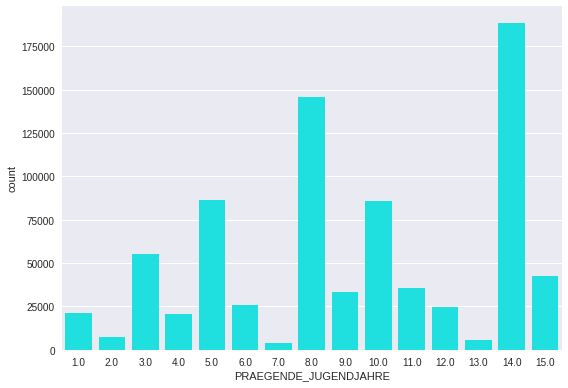

In [41]:
plt.style.use('seaborn')
sns.countplot(data=azdias_keep, x=azdias_keep['PRAEGENDE_JUGENDJAHRE'], color='aqua')
plt.tight_layout()
plt.show()

#from Data_Dictionary.md

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)



In [39]:
# engineer two new variables

# firstly create Generation decade

def decade_code(x):
    if x in (1,2):
        return '40s'
    if x in (3,4):
        return '50s'
    if x in (5,6,7):
        return '60s'
    if x in (8,9):
        return '70s'
    if x in (10,11,12,13):
        return '80s'
    if x in (14,15):
        return '90s'

azdias_keep['PRAEGENDE_DECADE'] = azdias_keep['PRAEGENDE_JUGENDJAHRE'].apply(decade_code)
    

# secondly create Generation movement

def movement_code(x):
    if x in (1,3,5,8,10,12,14):
        return 'Mainstream'
    if x in (2,4,6,7,9,11,13,15):
        return 'Avantgarde'
    
azdias_keep['PRAEGENDE_MOVEMENT'] = azdias_keep['PRAEGENDE_JUGENDJAHRE'].apply(movement_code)



In [41]:
azdias_keep[['PRAEGENDE_DECADE', 'PRAEGENDE_JUGENDJAHRE']].head()

,PRAEGENDE_DECADE,PRAEGENDE_JUGENDJAHRE
0,None,NaN
1,90s,14.0
2,90s,15.0
3,70s,8.0
4,70s,8.0


In [42]:
azdias_keep[['PRAEGENDE_MOVEMENT', 'PRAEGENDE_JUGENDJAHRE']].head()

,PRAEGENDE_MOVEMENT,PRAEGENDE_JUGENDJAHRE
0,None,NaN
1,Mainstream,14.0
2,Avantgarde,15.0
3,Mainstream,8.0
4,Mainstream,8.0


In [62]:
# Investigate "CAMEO_INTL_2015"
azdias['CAMEO_INTL_2015'].unique()

array([nan, '51', '24', '12', '43', '54', '22', '14', '13', '15', '33',
       '41', '34', '55', '25', '23', '31', '52', '35', '45', '44', '32'], dtype=object)

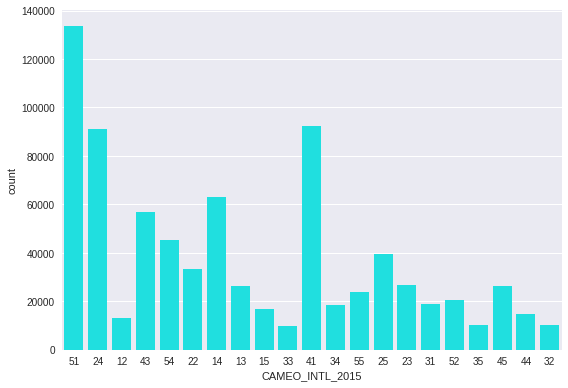

In [42]:
plt.style.use('seaborn')
sns.countplot(data=azdias_keep, x=azdias_keep['CAMEO_INTL_2015'], color='aqua')
plt.tight_layout()
plt.show()

#from Data_Dictionary.md

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown


In [43]:
#engineer two new variables
azdias_keep['CAMEO_INTL_2015_wealth'] = azdias_keep['CAMEO_INTL_2015'].str[0]
azdias_keep['CAMEO_INTL_2015_life_stage'] = azdias_keep['CAMEO_INTL_2015'].str[1]

# check if the variables are created correctly
azdias_keep[['CAMEO_INTL_2015', 'CAMEO_INTL_2015_wealth', 'CAMEO_INTL_2015_life_stage' ]].head()

,CAMEO_INTL_2015,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_stage
0,NaN,NaN,NaN
1,51,5,1
2,24,2,4
3,12,1,2
4,43,4,3


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

The mixed-value features within PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 is very well defined and can be easily split into two columns for each of them; as a result, both PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 have two engineered features each. After creating new features, we can drop the original features (e.g. PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015) and use engineered features instead.

For PRAEGENDE_JUGENDJAHRE, two functions (decade_code & movement_code) were used to create two new features (e.g. PRAEGENDE_DECADE & PRAEGENDE_MOVEMENT); one-hot encoding will then be applied to PRAEGENDE_DECADE & PRAEGENDE_MOVEMENT later in this project.

For CAMEO_INTL_2015, since it contain two digits, we can simply use the first digit for denoting weath, and the second digit for life stage, using the .str method in pandas; one-hot encoding will also applied to these two newly engineered columns later in this project.

For the other mixed type features, since the "degree of mixing" is not too serious, i.e. heavy dominance by one feature instead of equal influence by two features (like PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 above), we can simply use one-hot encoding to process them for simplicity.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [36]:
temp_merge.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            797919, 797920, 797921, 797922, 797923, 797924, 797925, 797926,
            797927, 797928],
           dtype='int64', length=797929)

In [76]:
azdias_lt30m_merge.index

Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            891211, 891212, 891213, 891214, 891215, 891216, 891217, 891218,
            891219, 891220],
           dtype='int64', length=797929)

In [37]:
azdias_lt30m_merge.sum()

index    3.554556e+11
ord      7.979290e+05
dtype: float64

In [44]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Let also remove the rows with 30 or more missing values, after removing the 6 worst columns already
azdias_keep_lt30m = azdias_keep[azdias_keep.isnull().sum(axis=1) < 30] 


# remove column PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015
Further_col_drop = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
azdias_keep2_lt30m = azdias_keep_lt30m.drop(Further_col_drop, axis=1)


In [45]:
azdias_keep_lt30m.shape

(798010, 83)

In [46]:
azdias_keep2_lt30m.shape

(798010, 81)

In [47]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# One-hot encoding for mixed type features

Feature_further_onehotencode = \
['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_DECADE', 'PRAEGENDE_MOVEMENT',
'WOHNLAGE', 'CAMEO_INTL_2015_wealth', 'CAMEO_INTL_2015_life_stage', 'PLZ8_BAUMAX']

print(Feature_further_onehotencode)
azdias_keep_lt30m_ohe = pd.get_dummies(azdias_keep2_lt30m[Feature_further_onehotencode].astype(str))


['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_DECADE', 'PRAEGENDE_MOVEMENT', 'WOHNLAGE', 'CAMEO_INTL_2015_wealth', 'CAMEO_INTL_2015_life_stage', 'PLZ8_BAUMAX']


In [75]:
azdias_keep_lt30m_ohe.shape

(798010, 90)

In [112]:
azdias_keep_lt30m_ohe.index

Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            891211, 891212, 891213, 891214, 891215, 891216, 891217, 891218,
            891219, 891220],
           dtype='int64', length=798010)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [10]:
# since we need to transform Customers Data with using Demographic data's PCA and Scaler, 
# it's better not to use string categories here, but instead use Integer Encoding in the cell below

# def decade_code(x):
#     if x in (1,2):
#         return '40s'
#     if x in (3,4):
#         return '50s'
#     if x in (5,6,7):
#         return '60s'
#     if x in (8,9):
#         return '70s'
#     if x in (10,11,12,13):
#         return '80s'
#     if x in (14,15):
#         return '90s'

# def movement_code(x):
#     if x in (1,3,5,8,10,12,14):
#         return 'Mainstream'
#     if x in (2,4,6,7,9,11,13,15):
#         return 'Avantgarde'
    

In [53]:
# Since we need to apply 'transform' function to the Customers Data 
# In our case, one-hot encoding creates some missing columns in Customers Data
# as a result, dimension of Demographic Data is larger than Customers Data
# a quick fix would use Integer Encoding directly

def decade_code(x):
    if x in (1,2):
        return 1
    if x in (3,4):
        return 2
    if x in (5,6,7):
        return 3
    if x in (8,9):
        return 4
    if x in (10,11,12,13):
        return 5
    if x in (14,15):
        return 6

def movement_code(x):
    if x in (1,3,5,8,10,12,14):
        return 0
    if x in (2,4,6,7,9,11,13,15):
        return 1

In [128]:
# for data with one-hot encoded categorical features
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
    feat_info['missing_or_unknown_list'] = feat_info['missing_or_unknown'].apply(lambda x: x.strip('[').strip(']').split(','))

    cols = df.columns
    
    for col in cols:
        missing_value = feat_info[feat_info['attribute'] == col]['missing_or_unknown_list'] 
    
        for i in range(len(missing_value.iloc[0])):
            if missing_value.iloc[0][i] in ['-1', '0', '9']:
                missing_value.iloc[0][i] = int(missing_value.iloc[0][i])
        
        df[col] = df[col].replace(missing_value.iloc[0], np.nan)
    
    
    # remove selected columns and rows, ...
    
    Missing_value_dist = df.isnull().sum()/len(df)*100
    Cols_to_be_drop = Missing_value_dist[Missing_value_dist>20].index
    
    df_keep = df.drop(Cols_to_be_drop, axis=1)
    
    df_keep2 = df_keep[df_keep.isnull().sum(axis=1) < 30] 

    
    # select, re-encode, and engineer column values.
    
    Category_col_temp = feat_info[feat_info['type'] == 'categorical']['attribute']
    Category_col_keep = Category_col_temp[~Category_col_temp.isin(Cols_to_be_drop)]
    
    Features_no_reencode = ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']
    
    Features_reencode = []
    for fea in Category_col_keep:
        if fea not in Features_no_reencode: 
            Features_reencode.append(fea)
            
    df_keep_Cat_OHE = pd.get_dummies(df_keep2[Features_reencode].astype(str))
    
    Mix_col_temp = feat_info[(feat_info['type'] == 'mixed') ]['attribute']
    Mix_col = Mix_col_temp[~Mix_col_temp.isin(Cols_to_be_drop)]
    
    df_keep2['PRAEGENDE_DECADE'] = df_keep2['PRAEGENDE_JUGENDJAHRE'].apply(decade_code)
    df_keep2['PRAEGENDE_MOVEMENT'] = df_keep2['PRAEGENDE_JUGENDJAHRE'].apply(movement_code)
    
    df_keep2['CAMEO_INTL_2015_wealth'] = df_keep2['CAMEO_INTL_2015'].str[0]
    df_keep2['CAMEO_INTL_2015_life_stage'] = df_keep2['CAMEO_INTL_2015'].str[1]
    
    Further_col_drop = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
    df_keep3 = df_keep2.drop(Further_col_drop, axis=1)
    
    Feature_further_onehotencode = \
    ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_DECADE', 'PRAEGENDE_MOVEMENT', 'WOHNLAGE', 'CAMEO_INTL_2015_wealth', 'CAMEO_INTL_2015_life_stage', 'PLZ8_BAUMAX']

    df_keep_Mix_OHE = pd.get_dummies(df_keep3[Feature_further_onehotencode].astype(str))
    
    
    # Merge df_keep3 with df_keep_Cat_OHE and df_keep_Mix_OHE to get the full dataset
    
    df_keep4 = df_keep3.drop(Features_reencode, axis=1)
    df_keep5 = df_keep4.drop(Feature_further_onehotencode, axis=1)
    
    df_keep5['index'] = df_keep5.index
    print(df_keep5['index'])
    df_keep_Cat_OHE['index'] = df_keep_Cat_OHE.index
    print(df_keep_Cat_OHE['index'])
    df_keep_Mix_OHE['index'] = df_keep_Mix_OHE.index
    print(df_keep_Mix_OHE['index'])
    
    df_merge1 = pd.merge(df_keep5, df_keep_Cat_OHE, how='inner', on='index')
    df_merge2 = pd.merge(df_merge1, df_keep_Mix_OHE, how='inner', on='index')
    drop_index = ['index']
    df_final = df_merge2.drop(drop_index, axis=1)
    
    # Return the cleaned dataframe.
    
#     return df_keep2
    return df_final
    

In [201]:
# for data excluding categorical features - this one will be used until the end of project
def clean_data_without_categorical(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
    feat_info['missing_or_unknown_list'] = feat_info['missing_or_unknown'].apply(lambda x: x.strip('[').strip(']').split(','))

    cols = df.columns
    
    for col in cols:
        missing_value = feat_info[feat_info['attribute'] == col]['missing_or_unknown_list'] 
    
        for i in range(len(missing_value.iloc[0])):
            if missing_value.iloc[0][i] in ['-1', '0', '9']:
                missing_value.iloc[0][i] = int(missing_value.iloc[0][i])
        
        df[col] = df[col].replace(missing_value.iloc[0], np.nan)
    
    
    # remove selected columns and rows, ...
    
    Missing_value_dist = df.isnull().sum()/len(df)*100
    Cols_to_be_drop = Missing_value_dist[Missing_value_dist>20].index
    
    df_keep = df.drop(Cols_to_be_drop, axis=1)
    
    df_keep1 = df_keep[df_keep.isnull().sum(axis=1) < 30] 

    
    # select, re-encode, and engineer column values.
    
    Category_col_temp = feat_info[feat_info['type'] == 'categorical']['attribute']
    Category_col_keep = Category_col_temp[~Category_col_temp.isin(Cols_to_be_drop)]
    
    Features_no_reencode = ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']
    
    Features_reencode = []
    for fea in Category_col_keep:
        if fea not in Features_no_reencode: 
            Features_reencode.append(fea)
    
    # do not keep categorical variables in this version
    
#    df_keep_Cat_OHE = pd.get_dummies(df_keep2[Features_reencode].astype(str))
    
    Mix_col_temp = feat_info[(feat_info['type'] == 'mixed') ]['attribute']
    Mix_col = Mix_col_temp[~Mix_col_temp.isin(Cols_to_be_drop)]
  
    df_keep2 = df_keep1.drop(Features_reencode, axis=1)
    
    Columns_Kept_for_Customer = df_keep2.columns
    

    df_keep2['PRAEGENDE_DECADE'] = df_keep2['PRAEGENDE_JUGENDJAHRE'].apply(decade_code)
    df_keep2['PRAEGENDE_MOVEMENT'] = df_keep2['PRAEGENDE_JUGENDJAHRE'].apply(movement_code)
    
    df_keep2['CAMEO_INTL_2015_wealth'] = df_keep2['CAMEO_INTL_2015'].str[0]
    df_keep2['CAMEO_INTL_2015_life_stage'] = df_keep2['CAMEO_INTL_2015'].str[1]
    
    Further_col_drop = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
     
    df_keep3 = df_keep2.drop(Further_col_drop, axis=1)
     
#     Feature_further_onehotencode = \
#     ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_DECADE', 'PRAEGENDE_MOVEMENT', 'WOHNLAGE', 'CAMEO_INTL_2015_wealth', 'CAMEO_INTL_2015_life_stage', 'PLZ8_BAUMAX']

#     df_keep_Mix_OHE = pd.get_dummies(df_keep3[Feature_further_onehotencode].astype(str))
    
    
    # Merge df_keep3 with df_keep_Cat_OHE and df_keep_Mix_OHE to get the full dataset
    
    
    
#     df_keep5 = df_keep4.drop(Feature_further_onehotencode, axis=1)
#     df_keep5 = df_keep4
    
#     df_keep5['index'] = df_keep5.index
#     print(df_keep5['index'])
#     df_keep_Cat_OHE['index'] = df_keep_Cat_OHE.index
#     print(df_keep_Cat_OHE['index'])
#     df_keep_Mix_OHE['index'] = df_keep_Mix_OHE.index
#     print(df_keep_Mix_OHE['index'])
    
#     df_merge1 = pd.merge(df_keep5, df_keep_Cat_OHE, how='inner', on='index')
#     df_merge2 = pd.merge(df_keep5, df_keep_Mix_OHE, how='inner', on='index')
#     drop_index = ['index']
#     df_final = df_merge2.drop(drop_index, axis=1)
    
    # Return the cleaned dataframe.
    
    return df_keep3, Columns_Kept_for_Customer

#     return df_final

In [96]:
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

In [129]:
# data with one hot encoding on Categorical variables
df_formatted = clean_data(azdias)

/Users/chonchon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/chonchon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/chonchon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

1              1
2              2
3              3
4              4
5              5
6              6
7              7
8              8
9              9
10            10
12            12
13            13
15            15
16            16
18            18
19            19
20            20
21            21
22            22
23            23
25            25
26            26
27            27
28            28
29            29
31            31
32            32
33            33
34            34
36            36
           ...  
891191    891191
891192    891192
891193    891193
891194    891194
891195    891195
891196    891196
891197    891197
891198    891198
891199    891199
891200    891200
891201    891201
891202    891202
891203    891203
891204    891204
891205    891205
891206    891206
891207    891207
891208    891208
891209    891209
891210    891210
891211    891211
891212    891212
891213    891213
891214    891214
891215    891215
891216    891216
891217    891217
891218    8912

In [14]:
df_formatted.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GEBURTSJAHR',
       'GREEN_AVANTGARDE',
       ...
       'CAMEO_INTL_2015_life_stage_4', 'CAMEO_INTL_2015_life_stage_5',
       'CAMEO_INTL_2015_life_stage_X', 'CAMEO_INTL_2015_life_stage_nan',
       'PLZ8_BAUMAX_1.0', 'PLZ8_BAUMAX_2.0', 'PLZ8_BAUMAX_3.0',
       'PLZ8_BAUMAX_4.0', 'PLZ8_BAUMAX_5.0', 'PLZ8_BAUMAX_nan'],
      dtype='object', length=311)

In [15]:
df_formatted.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            798054, 798055, 798056, 798057, 798058, 798059, 798060, 798061,
            798062, 798063],
           dtype='int64', length=798064)

In [7]:
df_formatted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798064 entries, 0 to 798063
Columns: 311 entries, ALTERSKATEGORIE_GROB to PLZ8_BAUMAX_nan
dtypes: float64(36), int64(26), uint8(249)
memory usage: 573.1 MB


In [130]:
df_formatted.shape

(798061, 289)

In [138]:
df_formatted.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,CAMEO_INTL_2015_life_stage_4,CAMEO_INTL_2015_life_stage_5,CAMEO_INTL_2015_life_stage_X,CAMEO_INTL_2015_life_stage_nan,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,PLZ8_BAUMAX_nan
0,1,2,1,5,2,5,4,5,1996,0,...,0,0,0,0,1,0,0,0,0,0
1,3,2,1,4,1,2,3,5,1979,1,...,1,0,0,0,1,0,0,0,0,0
2,4,2,4,2,5,2,1,2,1957,0,...,0,0,0,0,1,0,0,0,0,0
3,3,1,4,3,4,1,3,2,1963,0,...,0,0,0,0,0,1,0,0,0,0
4,1,2,3,1,5,2,2,5,1943,0,...,1,0,0,0,1,0,0,0,0,0


In [131]:
for col in df_formatted.columns:
    print(col, df_formatted[col].unique())

ALTERSKATEGORIE_GROB [  1.   3.   4.   2.  nan]
ANREDE_KZ [2 1]
FINANZ_MINIMALIST [1 4 3 2 5]
FINANZ_SPARER [5 4 2 3 1]
FINANZ_VORSORGER [2 1 5 4 3]
FINANZ_ANLEGER [5 2 1 4 3]
FINANZ_UNAUFFAELLIGER [4 3 1 2 5]
FINANZ_HAUSBAUER [5 2 3 4 1]
GREEN_AVANTGARDE [0 1]
HEALTH_TYP [  3.   2.   1.  nan]
RETOURTYP_BK_S [  1.   3.   2.   5.   4.  nan]
SEMIO_SOZ [5 4 6 2 7 3 1]
SEMIO_FAM [4 1 5 7 2 6 3]
SEMIO_REL [4 3 2 7 5 1 6]
SEMIO_MAT [3 1 2 4 7 5 6]
SEMIO_VERT [1 4 7 2 6 5 3]
SEMIO_LUST [2 4 6 7 3 1 5]
SEMIO_ERL [2 6 7 4 5 1 3]
SEMIO_KULT [3 4 6 5 7 1 2]
SEMIO_RAT [6 4 3 2 7 5 1]
SEMIO_KRIT [4 7 3 1 5 6 2]
SEMIO_DOM [7 4 2 1 5 6 3]
SEMIO_KAEM [4 7 5 2 3 6 1]
SEMIO_PFLICHT [7 3 4 5 1 6 2]
SEMIO_TRADV [6 3 4 2 7 5 1]
SOHO_KZ [ 1.  0.]
VERS_TYP [  2.   1.  nan]
ANZ_PERSONEN [  2.   1.   0.   4.   3.   5.   6.   7.   8.  12.   9.  21.  10.  13.  11.
  14.  45.  20.  31.  37.  16.  22.  15.  23.  18.  35.  17.  40.  38.]
ANZ_TITEL [ 0.  1.  2.  4.  3.  6.]
HH_EINKOMMEN_SCORE [ 6.  4.  1.  5.  3.  2

LP_LEBENSPHASE_FEIN_26.0 [0 1]
LP_LEBENSPHASE_FEIN_27.0 [0 1]
LP_LEBENSPHASE_FEIN_28.0 [0 1]
LP_LEBENSPHASE_FEIN_29.0 [0 1]
LP_LEBENSPHASE_FEIN_3.0 [0 1]
LP_LEBENSPHASE_FEIN_30.0 [0 1]
LP_LEBENSPHASE_FEIN_31.0 [0 1]
LP_LEBENSPHASE_FEIN_32.0 [0 1]
LP_LEBENSPHASE_FEIN_33.0 [0 1]
LP_LEBENSPHASE_FEIN_34.0 [0 1]
LP_LEBENSPHASE_FEIN_35.0 [0 1]
LP_LEBENSPHASE_FEIN_36.0 [0 1]
LP_LEBENSPHASE_FEIN_37.0 [0 1]
LP_LEBENSPHASE_FEIN_38.0 [0 1]
LP_LEBENSPHASE_FEIN_39.0 [0 1]
LP_LEBENSPHASE_FEIN_4.0 [0 1]
LP_LEBENSPHASE_FEIN_40.0 [0 1]
LP_LEBENSPHASE_FEIN_5.0 [0 1]
LP_LEBENSPHASE_FEIN_6.0 [0 1]
LP_LEBENSPHASE_FEIN_7.0 [0 1]
LP_LEBENSPHASE_FEIN_8.0 [0 1]
LP_LEBENSPHASE_FEIN_9.0 [0 1]
LP_LEBENSPHASE_FEIN_nan [0 1]
LP_LEBENSPHASE_GROB_1.0 [0 1]
LP_LEBENSPHASE_GROB_10.0 [0 1]
LP_LEBENSPHASE_GROB_11.0 [0 1]
LP_LEBENSPHASE_GROB_12.0 [0 1]
LP_LEBENSPHASE_GROB_2.0 [0 1]
LP_LEBENSPHASE_GROB_3.0 [0 1]
LP_LEBENSPHASE_GROB_4.0 [0 1]
LP_LEBENSPHASE_GROB_5.0 [0 1]
LP_LEBENSPHASE_GROB_6.0 [1 0]
LP_LEBENSPHASE_GROB_7.

In [202]:
# data with one hot encoding on Categorical variables

df_formatted_noCat, Features_Kept_for_Customer = clean_data_without_categorical(azdias)

In [23]:
df_formatted_noCat.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GEBURTSJAHR',
       'GREEN_AVANTGARDE',
       ...
       'CAMEO_INTL_2015_life_stage_4', 'CAMEO_INTL_2015_life_stage_5',
       'CAMEO_INTL_2015_life_stage_X', 'CAMEO_INTL_2015_life_stage_nan',
       'PLZ8_BAUMAX_1.0', 'PLZ8_BAUMAX_2.0', 'PLZ8_BAUMAX_3.0',
       'PLZ8_BAUMAX_4.0', 'PLZ8_BAUMAX_5.0', 'PLZ8_BAUMAX_nan'],
      dtype='object', length=156)

In [203]:
df_formatted_noCat.shape

(798061, 67)

In [71]:
df_formatted_noCat.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_DECADE,PRAEGENDE_MOVEMENT,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_stage
1,1,2,1,5,2,5,4,5,1996,0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,0.0,5,1
2,3,2,1,4,1,2,3,5,1979,1,...,1.0,4.0,4.0,3.0,5.0,2.0,6.0,1.0,2,4
3,4,2,4,2,5,2,1,2,1957,0,...,1.0,3.0,4.0,2.0,3.0,3.0,4.0,0.0,1,2
4,3,1,4,3,4,1,3,2,1963,0,...,2.0,3.0,3.0,4.0,6.0,5.0,4.0,0.0,4,3
5,1,2,3,1,5,2,2,5,1943,0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,0.0,5,4


In [119]:
for col in df_formatted_noCat.columns:
    print(col, df_formatted_noCat[col].unique())

ALTERSKATEGORIE_GROB [  1.   3.   4.   2.  nan]
ANREDE_KZ [2 1]
FINANZ_MINIMALIST [1 4 3 2 5]
FINANZ_SPARER [5 4 2 3 1]
FINANZ_VORSORGER [2 1 5 4 3]
FINANZ_ANLEGER [5 2 1 4 3]
FINANZ_UNAUFFAELLIGER [4 3 1 2 5]
FINANZ_HAUSBAUER [5 2 3 4 1]
GREEN_AVANTGARDE [0 1]
HEALTH_TYP [  3.   2.   1.  nan]
LP_LEBENSPHASE_FEIN [ 21.   3.  nan  32.   8.   2.   5.  10.   4.   6.  23.  12.  20.   1.  11.
  25.  13.  18.  31.  38.  35.  30.   7.  22.  14.  29.  24.  28.  37.  26.
  39.  27.  36.   9.  34.  33.  15.  40.  16.  19.  17.]
LP_LEBENSPHASE_GROB [  6.   1.  nan  10.   2.   3.   5.   7.  12.  11.   9.   4.   8.]
RETOURTYP_BK_S [  1.   3.   2.   5.   4.  nan]
SEMIO_SOZ [5 4 6 2 7 3 1]
SEMIO_FAM [4 1 5 7 2 6 3]
SEMIO_REL [4 3 2 7 5 1 6]
SEMIO_MAT [3 1 2 4 7 5 6]
SEMIO_VERT [1 4 7 2 6 5 3]
SEMIO_LUST [2 4 6 7 3 1 5]
SEMIO_ERL [2 6 7 4 5 1 3]
SEMIO_KULT [3 4 6 5 7 1 2]
SEMIO_RAT [6 4 3 2 7 5 1]
SEMIO_KRIT [4 7 3 1 5 6 2]
SEMIO_DOM [7 4 2 1 5 6 3]
SEMIO_KAEM [4 7 5 2 3 6 1]
SEMIO_PFLICHT [7 3 4 5 1 

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [19]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

print("Missing data volume in data with one-hot encoded Categorical variables:", df_formatted.isnull().sum().sum())

print("Missing data volume in Data without Categorical variables:", df_formatted_noCat.isnull().sum().sum())

Missing data volume in data with one-hot encoded Categorical variables: 550900
Missing data volume in Data without Categorical variables: 550900


In [9]:
# replace NaN with zero - this is probably not a very good idea (after reading the review of my first submission)

# df_formatted.fillna(0, inplace=True)  # used in first attempt, no longer use this in this attempt
# df_formatted_noCat.fillna(0, inplace=True) # used in first attempt, no longer use this in this attempt

In [22]:
import sklearn
sklearn.__version__

'0.22.2.post1'

In [132]:
# instead, let's replace missing data with mode, i.e. most frequent value in each column
# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer

Impute_mode = SimpleImputer(strategy="most_frequent")

df_imputed = pd.DataFrame(Impute_mode.fit_transform(df_formatted))

In [121]:
df_imputed_noCat = pd.DataFrame(Impute_mode.fit_transform(df_formatted_noCat))

In [210]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [133]:
df_scaled = scaler.fit_transform(df_imputed)   # with categorical features

In [211]:
df_scaled_noCat = scaler.fit_transform(df_imputed_noCat)   # without categorical features

In [212]:
print(df_scaled.shape)
print(df_scaled_noCat.shape)

(798061, 289)
(798061, 67)


In [135]:
df_scaled[:5]

array([[-1.76664565,  0.95791438, -1.49459382, ..., -0.2765099 ,
        -0.3726965 , -0.17362868],
       [ 0.20052242,  0.95791438, -1.49459382, ..., -0.2765099 ,
        -0.3726965 , -0.17362868],
       [ 1.18410646,  0.95791438,  0.6831445 , ..., -0.2765099 ,
        -0.3726965 , -0.17362868],
       [ 0.20052242, -1.04393463,  0.6831445 , ..., -0.2765099 ,
        -0.3726965 , -0.17362868],
       [-1.76664565,  0.95791438, -0.04276828, ..., -0.2765099 ,
        -0.3726965 , -0.17362868]])

In [125]:
df_scaled_noCat[:5]

array([[ -1.76664565e+00,   9.57914382e-01,  -1.49459382e+00,
          1.53792358e+00,  -1.04069177e+00,   1.46596530e+00,
          9.58645465e-01,   1.33931378e+00,  -5.30409362e-01,
          1.01016402e+00,   4.55782587e-01,   3.32258423e-01,
         -1.68544487e+00,   4.43199130e-01,  -5.93521610e-02,
          2.84384566e-03,  -4.63904428e-01,  -1.68451434e+00,
         -1.10990720e+00,  -1.43537601e+00,  -5.78167045e-01,
          1.27418202e+00,  -3.12190343e-01,   1.33925904e+00,
         -1.57562285e-01,   1.51869521e+00,   1.28898168e+00,
          1.08541291e+01,   9.22944100e-01,   2.34451396e-01,
         -6.04077759e-02,   1.02671425e+00,  -7.30189700e-01,
          5.67324588e-01,   1.73102757e-01,  -1.25133770e-01,
         -1.30453372e+00,  -3.83169751e-01,  -2.71084458e-02,
         -1.00884352e+00,  -9.65697335e-01,  -5.94877069e-01,
          2.73066257e+00,  -1.65926845e+00,   8.45251435e-01,
         -5.47162999e-01,   1.70110401e+00,  -7.99737221e-01,
        

In [150]:
# MinMax Scaler transform data in a different way - we will not apply PCA to the transformed data here

from sklearn.preprocessing import MinMaxScaler
MMscaler = MinMaxScaler()

df_scaled_MM = MMscaler.fit_transform(df_formatted)  

In [151]:
df_scaled_MM[:5]

array([[ 0.   ,  1.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.25 ,  1.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.375,  1.   ,  0.75 , ...,  0.   ,  0.   ,  0.   ],
       [ 0.25 ,  0.   ,  0.75 , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  1.   ,  0.5  , ...,  0.   ,  0.   ,  0.   ]])

In [126]:
df_formatted_noCat.keys()

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'WOHNLAGE', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
       'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', '

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

There are 550,900 missing values that need to be cleaned. 

In my first my first submission of this project, all missing values were simply replaced with zeros.

However, after reading the review of my first submission, I realized filling missing value with zeros may not be the most appropriate method, as some features (such as ANZ_TITEL ANZ_HH_TITEL ONLINE_AFFINITAET PLZ8_ANTG1 PLZ8_ANTG2) already have zero in their values; if doing so, the new zeros (converted from missing data) would probably mess up existing zeros, which in turn weaken the clustering algorithm.

Another approach, though less than perfect, would be to replace missing values with the mode in their respective columns, i.e. with the most frequent value in corresponding column. The advantage of this method is that true values for certain proportion of missing values are indeed captured by the mode.


As for feature scaling, two common choices are MinMaxScaler and StandardScaler.

Essentially, MinMaxScaler preserves the shape of the original distribution, and doesn’t reduce the importance of outliers; default range for the feature returned by MinMaxScaler is 0 to 1.

StandardScaler, on the other hand, removes the mean from data, and scales them to unit variance. In PCA, data are required to have zero mean and unit variance, which makes StandardScaler a better candidate in our case (as we would need to perform PCA in later steps).


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [136]:
from sklearn.decomposition import PCA

def do_pca(n_components, data):
    pca = PCA(n_components)   # PCA object
    X_pca = pca.fit_transform(data)   # data transformed by PCA 
    return pca, X_pca

In [137]:
# Apply PCA to the data - with one-hot encoded categorical variables

from sklearn.decomposition import PCA

df = df_scaled # put scaled data into df dataframe

pca, x_pca = do_pca(60, df)

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())


[ 0.0630155   0.044452    0.0252215   0.02321643  0.02037435  0.01924599
  0.01660511  0.01560488  0.01499926  0.01450267  0.0142041   0.01386243
  0.01298197  0.01228224  0.01148934  0.01099201  0.01072439  0.01052723
  0.00974634  0.00941029  0.00914239  0.00862979  0.0084822   0.00836184
  0.00824633  0.00802834  0.00786936  0.00764824  0.00750883  0.00736335
  0.00727741  0.00723244  0.00695026  0.0067996   0.00670776  0.00622329
  0.0059353   0.0059117   0.00571378  0.00565863  0.00537005  0.00528071
  0.00522631  0.00510513  0.00500162  0.00481838  0.00466968  0.00460444
  0.00450136  0.00433998  0.00426432  0.0041821   0.00408873  0.00404134
  0.00398596  0.00392709  0.00387479  0.0038203   0.00380149  0.00373153]
0.607784213809


In [138]:
# Apply PCA to the data - without categorical variables

from sklearn.decomposition import PCA

df_noCat = df_scaled_noCat # put scaled data into df dataframe

pca_noCat, x_pca_noCat = do_pca(60, df_noCat)

print(pca_noCat.explained_variance_ratio_)
print(pca_noCat.explained_variance_ratio_.sum())


[ 0.17204094  0.12852077  0.09071483  0.05671603  0.04070714  0.03250341
  0.03012279  0.0255657   0.02386706  0.02270831  0.0199314   0.01877244
  0.01791029  0.01697483  0.01574367  0.01492315  0.01428687  0.01355924
  0.01263651  0.01212261  0.01176787  0.01111036  0.01091077  0.01061037
  0.00996481  0.00874445  0.00847519  0.00757008  0.00750158  0.0070584
  0.00678777  0.00647579  0.0062013   0.00607826  0.00591761  0.00581097
  0.00537333  0.00507154  0.00465473  0.004343    0.00430665  0.00426308
  0.00394198  0.00388766  0.00373977  0.00365685  0.00360241  0.00358659
  0.00337189  0.00312307  0.00294431  0.00289482  0.00278652  0.00264769
  0.00256534  0.0024668   0.0022576   0.0021141   0.00194233  0.0019117 ]
0.992767284675


In [144]:
# Apply PCA to the data - without categorical variables ( use less components)

from sklearn.decomposition import PCA

df_noCat = df_scaled_noCat # put scaled data into df dataframe

pca_noCat, x_pca_noCat = do_pca(27, df_noCat)

print(pca_noCat.explained_variance_ratio_)
print(pca_noCat.explained_variance_ratio_.sum())

[ 0.17204094  0.12852077  0.09071483  0.05671603  0.04070714  0.03250341
  0.03012278  0.02556569  0.02386704  0.02270822  0.0199312   0.0187723
  0.01791     0.01697468  0.01574263  0.01492278  0.01428565  0.01355803
  0.01262918  0.01212164  0.01176592  0.01110737  0.0109011   0.01059995
  0.00994978  0.00869689  0.00842586]
0.851761821104


In [139]:
# Investigate the variance accounted for by each principal component.

print("Keeping one-hot encoded categorical variables makes PCA less effective")
print("First 60 components only explain {} % variation in data".format(int((pca.explained_variance_ratio_.sum())*100)))
print("\n")
print("Removing categorical variables makes PCA more effective")
print("First 60 components now explain {} % variation in data".format(int((pca_noCat.explained_variance_ratio_.sum())*100)))


Keeping one-hot encoded categorical variables makes PCA less effective
First 60 components only explain 60 % variation in data


Removing categorical variables makes PCA more effective
First 60 components now explain 99 % variation in data


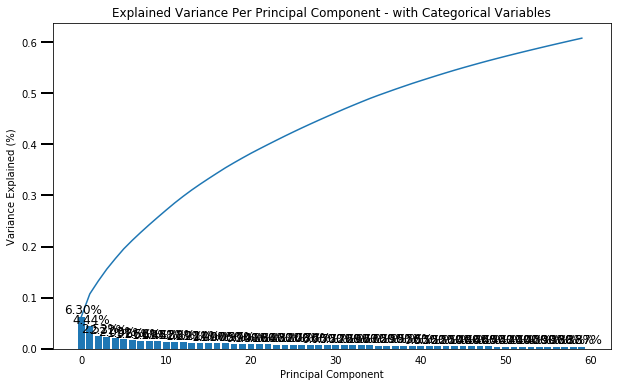

In [145]:
# plot Explained Variance Per Principal Component

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component - with Categorical Variables')


scree_plot(pca)

In [146]:
def scree_plot2(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component - without Categorical Variables')


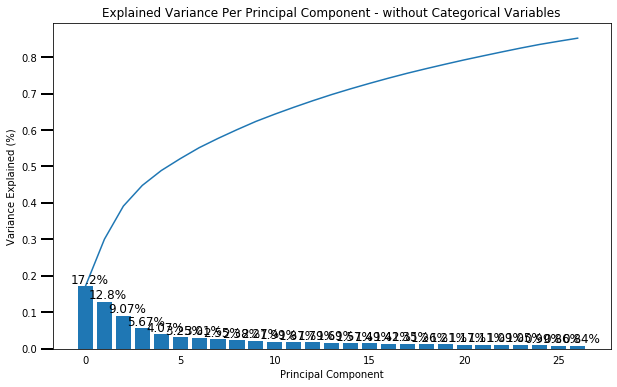

In [147]:
scree_plot2(pca_noCat)

Total data variation explained by 27 principal components: 85.1730641665


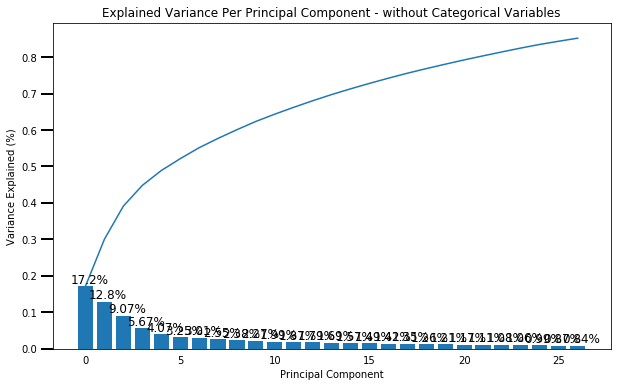

In [148]:
# Re-apply PCA to the data while selecting for number of components to retain.

df_noCat = df_scaled_noCat # put scaled data into df dataframe

pca_final, x_pca_final = do_pca(27, df_noCat)   # let's keep 80 components

print("Total data variation explained by 27 principal components:", pca_final.explained_variance_ratio_.sum()*100)

scree_plot2(pca_final)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

In my first trial, categorical variables (which were one-hot encoded) somehow made PCA ineffective (i.e. 60 components explained only 60% of data variations in Demographic Data. As a result, a decision to remove Categorical variables has been made.

In later steps, the PCA model built from Demographic Data will need to be applied to Customers Data. Since one-hot enocoding on PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 creates less columns in Customers Data than in Demographic Data, a decision to use Integer Encoding (or what's called Label Encoding in SKLearn) for PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 has been made; the PCA looks good after applying this, with 60 components capturing more than 99% of total variation in Demographic Data.

In the final PCA transformed dataset, 27 principal components are used, which explained more than 85% of the data variation in Demographic Data.


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [149]:
def pca_results(full_dataset, pca):


    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)


,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_DECADE,PRAEGENDE_MOVEMENT,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_stage
Dimension 1,0.1720,-0.0938,0.0112,-0.2048,0.1225,-0.0913,0.0480,0.0569,0.1622,-0.1036,...,0.2136,0.0434,-0.1652,0.1396,0.1978,0.1339,0.0827,-0.1036,0.1996,-0.1186
Dimension 2,0.1285,0.2695,0.0877,0.0887,-0.2491,0.2426,-0.2128,-0.2324,0.0988,-0.0008,...,0.0636,0.0116,-0.0530,0.0524,0.0730,0.0518,-0.2506,-0.0008,0.0508,0.0152
Dimension 3,0.0907,0.0776,-0.3678,0.1596,-0.1068,0.1005,-0.1908,-0.0979,-0.0474,0.0553,...,0.0473,0.0058,-0.0366,0.0331,0.0482,0.0315,-0.1097,0.0553,0.0224,-0.0068
Dimension 4,0.0567,-0.0439,0.0426,0.0639,-0.0004,-0.0249,-0.0898,0.0547,-0.1001,0.3453,...,0.0808,0.0816,-0.0169,0.0874,0.2422,0.1068,0.0340,0.3453,-0.0962,0.0511
Dimension 5,0.0407,0.0387,-0.0063,0.0293,-0.0073,0.0009,0.0746,-0.0769,-0.0363,-0.1586,...,0.0897,-0.2388,-0.2442,0.0706,-0.0299,0.0449,0.0088,-0.1586,0.1041,-0.0725
Dimension 6,0.0325,0.0325,-0.0039,-0.0543,0.0047,0.0306,0.0032,0.0077,0.0321,-0.0683,...,-0.0049,0.4516,0.2953,-0.2189,-0.0946,-0.1976,0.0114,-0.0683,0.0220,-0.0382
Dimension 7,0.0301,-0.0109,0.0219,0.0130,-0.0007,-0.0421,-0.0108,0.0107,-0.0310,0.0763,...,0.0896,-0.2453,-0.2297,-0.1459,-0.0449,-0.1537,0.0219,0.0763,-0.1026,0.0618
Dimension 8,0.0256,0.0060,0.0577,-0.0716,-0.0394,0.0276,-0.0388,-0.0690,0.1934,-0.0144,...,0.0799,-0.1430,-0.1273,-0.0910,-0.1764,-0.0558,-0.0727,-0.0144,0.0641,-0.0064
Dimension 9,0.0239,-0.0743,-0.0218,-0.0873,0.0393,0.0397,0.0576,-0.0850,0.1917,-0.0511,...,0.0135,0.0545,0.0514,-0.0161,-0.0058,-0.0085,-0.0062,-0.0511,0.0243,0.0254
Dimension 10,0.0227,-0.1308,0.0883,0.0866,-0.2007,0.1899,-0.1516,-0.2053,0.0765,-0.0817,...,-0.0745,0.0700,0.0867,0.1045,0.0826,0.0597,-0.2221,-0.0817,-0.0176,0.0796


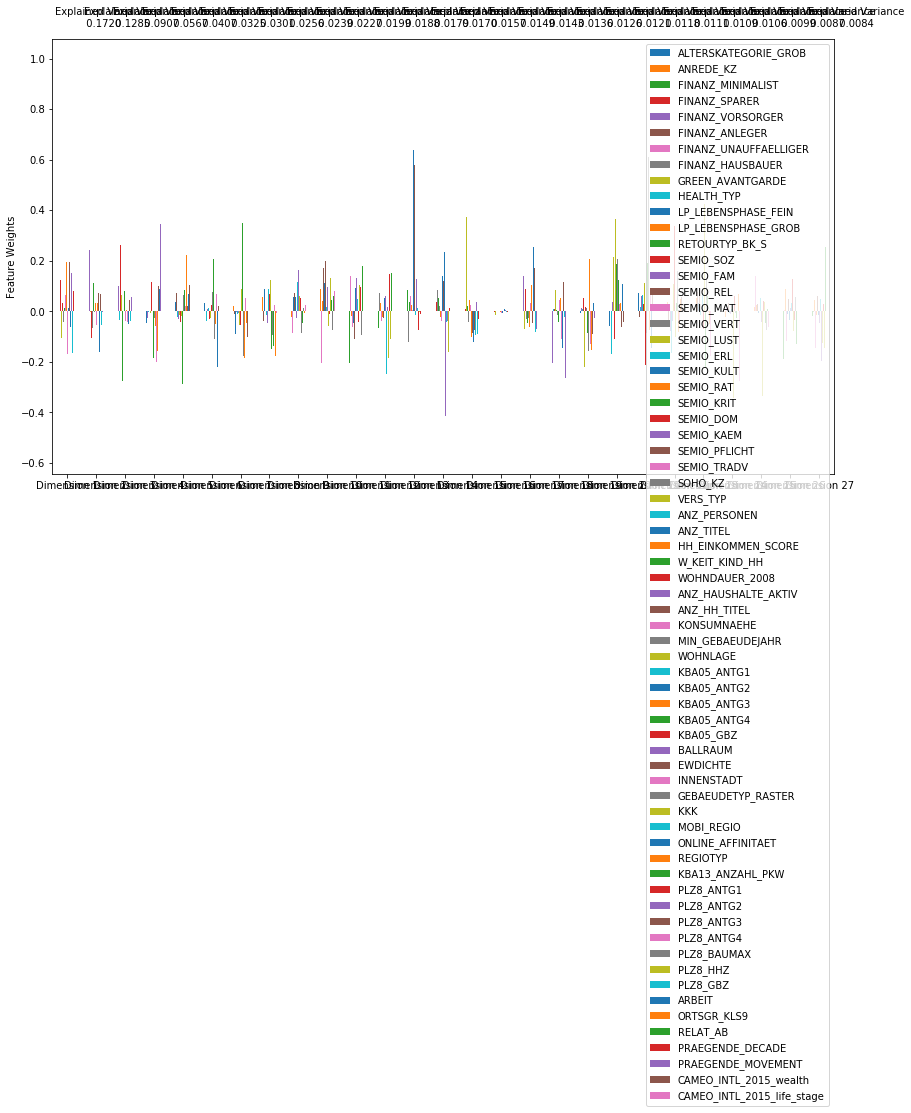

In [150]:
pca_results(df_formatted_noCat, pca_final)

In [151]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def weight_extract(pca, comp_order, full_dataset):
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    weights = components.iloc[comp_order].sort_values(ascending=False)
    return weights

pca_1st_comp = weight_extract(pca_final, 0, df_formatted_noCat)
print (pca_1st_comp)

PLZ8_ANTG3                    0.2241
PLZ8_ANTG4                    0.2169
PLZ8_BAUMAX                   0.2136
CAMEO_INTL_2015_wealth        0.1996
ORTSGR_KLS9                   0.1978
HH_EINKOMMEN_SCORE            0.1966
EWDICHTE                      0.1957
FINANZ_HAUSBAUER              0.1622
PLZ8_ANTG2                    0.1535
KBA05_ANTG4                   0.1523
ARBEIT                        0.1396
ANZ_HAUSHALTE_AKTIV           0.1345
RELAT_AB                      0.1339
KBA05_ANTG3                   0.1331
FINANZ_SPARER                 0.1225
SEMIO_PFLICHT                 0.0929
SEMIO_REL                     0.0898
PRAEGENDE_DECADE              0.0827
SEMIO_RAT                     0.0759
SEMIO_TRADV                   0.0665
SEMIO_MAT                     0.0638
SEMIO_FAM                     0.0630
W_KEIT_KIND_HH                0.0578
FINANZ_UNAUFFAELLIGER         0.0569
REGIOTYP                      0.0553
SEMIO_KULT                    0.0534
FINANZ_ANLEGER                0.0480
S

In [154]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_2nd_comp = weight_extract(pca_final, 1, df_formatted_noCat)
print (pca_2nd_comp)

ALTERSKATEGORIE_GROB          0.2695
FINANZ_VORSORGER              0.2426
SEMIO_ERL                     0.2353
SEMIO_LUST                    0.1883
RETOURTYP_BK_S                0.1636
SEMIO_KRIT                    0.1141
W_KEIT_KIND_HH                0.1126
SEMIO_KAEM                    0.1071
FINANZ_HAUSBAUER              0.0988
FINANZ_MINIMALIST             0.0887
ANREDE_KZ                     0.0877
EWDICHTE                      0.0743
ORTSGR_KLS9                   0.0730
PLZ8_ANTG3                    0.0695
SEMIO_DOM                     0.0688
PLZ8_ANTG4                    0.0687
WOHNDAUER_2008                0.0646
PLZ8_BAUMAX                   0.0636
KBA05_ANTG4                   0.0541
ARBEIT                        0.0524
RELAT_AB                      0.0518
CAMEO_INTL_2015_wealth        0.0508
PLZ8_ANTG2                    0.0490
ANZ_HAUSHALTE_AKTIV           0.0478
HH_EINKOMMEN_SCORE            0.0336
KBA05_ANTG3                   0.0317
VERS_TYP                      0.0279
A

In [155]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_3rd_comp = weight_extract(pca_final, 2, df_formatted_noCat)
print (pca_3rd_comp)

SEMIO_VERT                0.3459
SEMIO_SOZ                 0.2622
SEMIO_FAM                 0.2491
SEMIO_KULT                0.2350
FINANZ_MINIMALIST         0.1596
RETOURTYP_BK_S            0.1063
FINANZ_VORSORGER          0.1005
W_KEIT_KIND_HH            0.0794
ALTERSKATEGORIE_GROB      0.0776
SEMIO_REL                 0.0688
SEMIO_LUST                0.0631
SEMIO_MAT                 0.0562
GREEN_AVANTGARDE          0.0553
PRAEGENDE_MOVEMENT        0.0553
ORTSGR_KLS9               0.0482
EWDICHTE                  0.0473
PLZ8_BAUMAX               0.0473
PLZ8_ANTG4                0.0452
PLZ8_ANTG3                0.0437
WOHNDAUER_2008            0.0337
ARBEIT                    0.0331
RELAT_AB                  0.0315
PLZ8_ANTG2                0.0298
KBA05_ANTG4               0.0249
CAMEO_INTL_2015_wealth    0.0224
ANZ_HAUSHALTE_AKTIV       0.0220
ANZ_HH_TITEL              0.0129
ANZ_TITEL                 0.0101
LP_LEBENSPHASE_FEIN       0.0091
KBA05_ANTG3               0.0067
          

In [268]:
pca_4th_comp = weight_extract(pca_final, 3, df_formatted_noCat)
print(pca_4th_comp)

GREEN_AVANTGARDE              0.3453
PRAEGENDE_MOVEMENT            0.3453
ORTSGR_KLS9                   0.2422
EWDICHTE                      0.2399
LP_LEBENSPHASE_FEIN           0.2341
LP_LEBENSPHASE_GROB           0.2299
ANZ_PERSONEN                  0.2133
ONLINE_AFFINITAET             0.1798
SEMIO_DOM                     0.1157
RELAT_AB                      0.1068
PLZ8_ANTG3                    0.1013
PLZ8_ANTG4                    0.0908
PLZ8_ANTG2                    0.0882
ARBEIT                        0.0874
SEMIO_KAEM                    0.0848
KBA05_ANTG1                   0.0835
PLZ8_HHZ                      0.0816
PLZ8_BAUMAX                   0.0808
FINANZ_MINIMALIST             0.0639
MOBI_REGIO                    0.0574
FINANZ_UNAUFFAELLIGER         0.0547
SEMIO_TRADV                   0.0526
SEMIO_RAT                     0.0521
CAMEO_INTL_2015_life_stage    0.0511
KBA05_GBZ                     0.0428
ANREDE_KZ                     0.0426
WOHNDAUER_2008                0.0418
A

In [278]:
pca_5th_comp = weight_extract(pca_final, 4, df_formatted_noCat)
print(pca_5th_comp)

LP_LEBENSPHASE_GROB           0.3684
LP_LEBENSPHASE_FEIN           0.3572
ANZ_PERSONEN                  0.3510
KKK                           0.2686
REGIOTYP                      0.2232
ONLINE_AFFINITAET             0.1467
WOHNLAGE                      0.1224
CAMEO_INTL_2015_wealth        0.1041
WOHNDAUER_2008                0.1016
PLZ8_BAUMAX                   0.0897
KBA05_ANTG4                   0.0863
KONSUMNAEHE                   0.0851
FINANZ_ANLEGER                0.0746
HH_EINKOMMEN_SCORE            0.0736
ARBEIT                        0.0706
MIN_GEBAEUDEJAHR              0.0660
PLZ8_ANTG4                    0.0623
BALLRAUM                      0.0524
ANZ_HAUSHALTE_AKTIV           0.0497
SEMIO_ERL                     0.0491
RELAT_AB                      0.0449
ALTERSKATEGORIE_GROB          0.0387
GEBAEUDETYP_RASTER            0.0384
FINANZ_MINIMALIST             0.0293
INNENSTADT                    0.0233
KBA05_ANTG3                   0.0209
PLZ8_ANTG3                    0.0198
S

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)


For the 1st principal component, it is strongly correlated to wealthy people who live in particular wealthy region with significant number of 6+ persons family houses; it is negatively related to people with low financial interest and low movement pattern, who normally live in an area with smaller house size (1-2 persons); this group is also negatively related to high density areas (e.g. areas with lots of buildings), and they tend to live close to city center. 
Let's call this group "Wealthy people".


The 2nd principal component is strongly related to people who were typically borned in the 40s/50s and are now more than 60 years old; they tend to save and invest money and are financially prepared; they show low affinity to at least three personality traits: event-oriented, sensual-minded, & critical-minded; these people are also characterized as "determined Minimal-Returner", meaning that there is low probability of them being loyal return customers.
In addition, people in 2nd principal component show high affinity to 5 personality traits: religious, dutiful, tradional-minded, cultural-minded, financially inconspicuous.
Let's call this group "Retired people with financial preparation".


The 3rd principal component appears to represent a particular male subgroup who are dreamful, sociable, family-minded, cultural-minded; this subgroup shows high affinity to 4 personality traits: combative, dominant-minded, rational, and event-oriented. Also, they don't have strong interest in finance.
Let's call this group "Self-sufficient Male Subgroup".


The 4th principal component appears to represent a particular group of people who are member of green avantgarde and had joined movement; They tend to belong to a large community locating in high density area; they tend to live with multipersons in same household within a good-quality neighborhood, which are wihtin short distance to urban center/city center. They are typically high-income earners. 
Let's call this group "Urban professionals with a sense of purpose".


The 5th principal component appears to represent households with high number of low-income earners; these people tend to have children and live in low-desity, low-income neighborhoods with limited number of cars passing by. Also, these people typically had not joined movement, and are not a member of green avantgarde. 
Let's call this group "Low-income households".


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [156]:
# pca transformed data check
x_pca_final.shape

(798061, 27)

In [158]:
x_pca_final[:3]

array([[  3.26640631,  -3.01872941,  -2.96489621,  -0.21228899,
          0.20731302,   3.36550081,   0.66802912,   0.5411122 ,
          1.9560692 ,  -0.58472765,   0.17665619,   1.13570943,
         -0.76920313,  -2.57231563,   0.67660823,  10.8238032 ,
         -0.58231415,  -1.07519964,   0.56715931,   1.34677266,
         -0.46297698,   1.29958381,  -1.24214465,   0.32372342,
          0.1323888 ,   0.04243223,   1.00764556],
       [ -0.61106041,   0.4696051 ,  -3.03068363,   1.54868646,
         -2.93983536,  -0.45813304,   0.08049078,   0.41237257,
          0.09489786,  -1.2629471 ,   1.39172705,   1.56750867,
         -0.75115715,   1.04490148,   1.09610561,  -0.18542046,
         -1.32032444,   0.0347354 ,   0.08201599,  -1.64252923,
         -0.12891227,  -0.23428417,  -0.86715075,  -1.19998931,
         -1.22620903,   0.75483065,  -0.39436781],
       [ -3.44806745,   1.74768001,  -0.71010064,  -2.15793142,
         -0.92240059,  -1.05288118,   0.81894359,  -0.77245987,
  

In [22]:
pd.DataFrame(x_pca_final).to_csv('Udacity_AZDIAS_Subset_PCA_transformed.csv', sep=';')

In [23]:
azdias_PCA_final = pd.read_csv('Udacity_AZDIAS_Subset_PCA_transformed.csv', sep=';')

In [24]:
azdias_PCA_final.shape

(798064, 81)

In [159]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans

def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)

    # Obtain a score related to the model fit
    score = np.abs(model.score(data))

    return score


def fit_mods():
    scores = []
    centers = list(range(1,26))

    for center in centers:
        scores.append(get_kmeans_score(x_pca_final, center))

    return centers, scores


# run k-means clustering on the data and...
    
centers, scores = fit_mods()


In [160]:
# compute the average within-cluster distances.

for i in np.arange(0, 25):
    print( "For {} clusters, average within-cluster distances = {}".format( (i+1), scores[i]/x_pca_final.shape[0] ) ) 
    

For 1 clusters, average within-cluster distances = 57.065952991536484
For 2 clusters, average within-cluster distances = 48.46357983058177
For 3 clusters, average within-cluster distances = 44.459578777111176
For 4 clusters, average within-cluster distances = 41.71152123299026
For 5 clusters, average within-cluster distances = 39.87419259585253
For 6 clusters, average within-cluster distances = 38.32951597935381
For 7 clusters, average within-cluster distances = 36.96603019621149
For 8 clusters, average within-cluster distances = 35.84809466253407
For 9 clusters, average within-cluster distances = 34.974934729749236
For 10 clusters, average within-cluster distances = 34.24102655581252
For 11 clusters, average within-cluster distances = 33.298437989358774
For 12 clusters, average within-cluster distances = 32.95723863288648
For 13 clusters, average within-cluster distances = 32.27406176938215
For 14 clusters, average within-cluster distances = 31.552036855004438
For 15 clusters, average

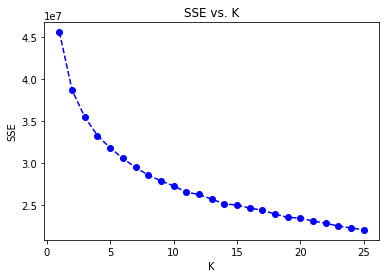

In [161]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');


In [163]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

from sklearn.cluster import KMeans

kmeans = KMeans( n_clusters=14 )
model_14_cluster = kmeans.fit(x_pca_final)
label_14_cluster = model_14_cluster.predict(x_pca_final)


In [166]:
x_pca_final.shape

(798061, 27)

In [167]:
label_14_cluster.shape

(798061,)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)


If we look the "SSE by number of cluster" plot, there is no clear L shape; SSE initially decreases dramatically when number of cluster is less than 5, but then the decrease rate kind of flattens afterwards.

If we look at "average within-cluster distances by number of cluster", subjectively we can say there is no more substantial decrease once the number of clusters exceed 14, as the difference between cluster 14 and 15 is only 0.4 ( in terms of average within-cluster distances.

As a results, 14 clusters have been chosen for this project.


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [172]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [169]:
customers.shape

(191652, 85)

In [181]:
df_formatted_noCat.shape

(798061, 67)

In [180]:
df_formatted_noCat.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'WOHNLAGE', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
       'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', '

In [205]:
# for data excluding categorical features - minor adjustment for Customer Data due to CAMEO_INTL_2015
def clean_data_Customer(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
    feat_info['missing_or_unknown_list'] = feat_info['missing_or_unknown'].apply(lambda x: x.strip('[').strip(']').split(','))

    cols = df.columns
    
    for col in cols:
        missing_value = feat_info[feat_info['attribute'] == col]['missing_or_unknown_list'] 
    
        for i in range(len(missing_value.iloc[0])):
            if missing_value.iloc[0][i] in ['-1', '0', '9']:
                missing_value.iloc[0][i] = int(missing_value.iloc[0][i])
        
        df[col] = df[col].replace(missing_value.iloc[0], np.nan)
    
    
    # remove selected columns and rows, ...
    
#     Missing_value_dist = df.isnull().sum()/len(df)*100

#     Cols_to_be_drop = Missing_value_dist[ (Missing_value_dist>20) & (Missing_value_dist.index !='CAMEO_INTL_2015') & (Missing_value_dist.index !='PRAEGENDE_JUGENDJAHRE') ].index  # Missing_value_dist!='CAMEO_INTL_2015'
    
    
    df_keep = df[Features_Kept_for_Customer]
    
    df_keep2 = df_keep[df_keep.isnull().sum(axis=1) < 30] 

    
    # select, re-encode, and engineer column values.
    
#     Category_col_temp = feat_info[feat_info['type'] == 'categorical']['attribute']
#     Category_col_keep = Category_col_temp[~Category_col_temp.isin(Cols_to_be_drop)]
    
#     Features_no_reencode = ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']
    
#     Features_reencode = []
#     for fea in Category_col_keep:
#         if fea not in Features_no_reencode: 
#             Features_reencode.append(fea)
    
    # do not keep categorical variables in this version
    
#    df_keep_Cat_OHE = pd.get_dummies(df_keep2[Features_reencode].astype(str))
    
#     Mix_col_temp = feat_info[(feat_info['type'] == 'mixed') ]['attribute']
#     Mix_col = Mix_col_temp[~Mix_col_temp.isin(Cols_to_be_drop)]
    
    df_keep2['PRAEGENDE_DECADE'] = df_keep2['PRAEGENDE_JUGENDJAHRE'].apply(decade_code)
    df_keep2['PRAEGENDE_MOVEMENT'] = df_keep2['PRAEGENDE_JUGENDJAHRE'].apply(movement_code)
    
    df_keep2['CAMEO_INTL_2015_wealth'] = df_keep2['CAMEO_INTL_2015'].str[0]
    df_keep2['CAMEO_INTL_2015_life_stage'] = df_keep2['CAMEO_INTL_2015'].str[1]
    
    Further_col_drop = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
    df_keep3 = df_keep2.drop(Further_col_drop, axis=1)
    
#     Feature_further_onehotencode = \
#     ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_DECADE', 'PRAEGENDE_MOVEMENT', 'WOHNLAGE', 'CAMEO_INTL_2015_wealth', 'CAMEO_INTL_2015_life_stage', 'PLZ8_BAUMAX']

#     df_keep_Mix_OHE = pd.get_dummies(df_keep3[Feature_further_onehotencode].astype(str))
    
    
    # Merge df_keep3 with df_keep_Cat_OHE and df_keep_Mix_OHE to get the full dataset
    
#     df_keep4 = df_keep3.drop(Features_reencode, axis=1)
    
#     df_keep5 = df_keep4.drop(Feature_further_onehotencode, axis=1)
#     df_keep5 = df_keep4
    
#     df_keep5['index'] = df_keep5.index
#     print(df_keep5['index'])
#     df_keep_Cat_OHE['index'] = df_keep_Cat_OHE.index
#     print(df_keep_Cat_OHE['index'])
#     df_keep_Mix_OHE['index'] = df_keep_Mix_OHE.index
#     print(df_keep_Mix_OHE['index'])
    
#     df_merge1 = pd.merge(df_keep5, df_keep_Cat_OHE, how='inner', on='index')
#     df_merge2 = pd.merge(df_keep5, df_keep_Mix_OHE, how='inner', on='index')
#     drop_index = ['index']
#     df_final = df_merge2.drop(drop_index, axis=1)
    
    # Return the cleaned dataframe.
    
    return df_keep3

#     return df_final

In [206]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_formatted_noCat = clean_data_Customer(customers)

/Users/chonchon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/chonchon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/chonchon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

In [207]:
customers_formatted_noCat.shape

(142555, 67)

In [208]:
# Imputation of missing data
customers_imputed_noCat = pd.DataFrame(Impute_mode.fit_transform(customers_formatted_noCat))

In [213]:
# Features scaling
customers_scaled_noCat = scaler.transform(customers_imputed_noCat) 

In [214]:
# Apply PCA (built from Demographic Data) to Customers Data
x_pca_customers = pca_final.transform(customers_scaled_noCat)


In [215]:
Customer_label_14_cluster = model_14_cluster.predict(x_pca_customers)

In [216]:
Customer_label_14_cluster.shape

(142555,)

In [282]:
# Distribution of Customer Labels

Customer_lable_count = pd.DataFrame(Customer_label_14_cluster, columns=['Cluster'])
Customer_lable_count['%'] = 1
Customer_proportion = Customer_lable_count.groupby(['Cluster']).sum()/len(Customer_lable_count)*100
Customer_proportion['index'] = Customer_proportion.index
Customer_proportion

,%,index
Cluster,,
0,1.120971,0
1,0.917541,1
2,1.378415,2
3,6.458560,3
4,33.345025,4
5,16.604819,5
6,2.004840,6
7,6.951703,7
8,7.574620,8


In [281]:
# Distribution of Demographic data Labels

Demo_lable_count = pd.DataFrame(label_14_cluster, columns=['Cluster'])
Demo_lable_count['%'] = 1
Demo_proportion = Demo_lable_count.groupby(['Cluster']).sum()/len(Demo_lable_count)*100
Demo_proportion['index'] = Demo_proportion.index
Demo_proportion

,%,index
Cluster,,
0,3.057034,0
1,9.898241,1
2,10.058254,2
3,8.936159,3
4,6.965257,4
5,8.344224,5
6,5.446576,6
7,7.955282,7
8,7.996256,8


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

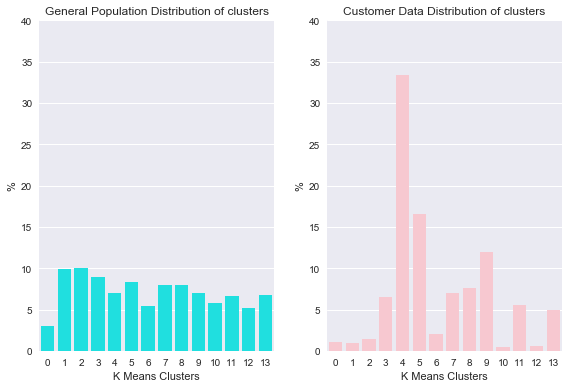

In [252]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

plt.style.use('seaborn')

fig, (ax1, ax2) = plt.subplots( nrows=1, ncols=2 )

ax1.set( ylim=(0, int(Customer_proportion['%'].max()*1.2) ) ) # ax1 and ax2 have the same axis scale
ax2.set( ylim=(0, int(Customer_proportion['%'].max()*1.2) ) )


sns.barplot(x=Demo_proportion['index'], y=Demo_proportion['%'], ax=ax1, color='aqua')
ax1.set_title('General Population Distribution of clusters')
ax1.set_xlabel("K Means Clusters")

sns.barplot(x=Customer_proportion['index'], y=Customer_proportion['%'], ax=ax2, color='pink')
ax2.set_title('Customer Data Distribution of clusters')
ax2.set_xlabel("K Means Clusters")

plt.tight_layout()
plt.show()

In [285]:
# Let's look at the cluster centers in terms of the first 5 principal components

print("K Means Cluster Centers' coordinates in terms of first 5 principal components")
print("\n")
for i in range(len(model_14_cluster.cluster_centers_)):
    print("Cluster {}: ".format(i), model_14_cluster.cluster_centers_[i][:5])
    

K Means Cluster Centers' coordinates in terms of first 5 principal components


Cluster 0:  [-1.5488623  -1.3063703  -0.59982256 -0.19163424  0.73593677]
Cluster 1:  [ 4.51126191 -1.4249463  -2.55307624  0.42397809 -0.03019627]
Cluster 2:  [-0.91115429 -3.00985514 -3.09778056 -0.12830212 -0.44119582]
Cluster 3:  [ 0.30146544  3.25410035 -1.72482203 -0.78740101 -0.39472798]
Cluster 4:  [-3.30404552  0.35479318  2.83011533  2.36165354 -0.79691087]
Cluster 5:  [-3.81057153 -0.16574433  1.73456113 -1.54786063  0.65600221]
Cluster 6:  [-2.14112094 -4.87404413  1.95130955  0.27118872  0.17912401]
Cluster 7:  [-3.76341919  1.43457661 -2.02860453 -1.31191456  0.72681696]
Cluster 8:  [ 0.25305872  1.18377194  2.41309268 -1.13839763 -0.35747537]
Cluster 9:  [-3.35918925  1.93637341 -1.55765088  2.80952762 -0.65639678]
Cluster 10:  [ 1.7933659  -3.5965043   1.89064245 -0.91186133 -0.714671  ]
Cluster 11:  [ 3.50959563  2.19887055  3.03880878  0.08953681  0.62075444]
Cluster 12:  [ 5.1876727  -2.3

In [283]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

Customer_proportion[Customer_proportion['%'] > Demo_proportion['%'] ].drop('index', axis=1)


,%
Cluster,
4,33.345025
5,16.604819
9,11.982042


Now we see that Cluster 4, 5 & 9 are overrepresented in Customers Data.

Let's recall in Discussion 2.3, we have characterized the first 5 princial components as follows:

1st Principal Component: "Wealthy people" <br>
2nd Principal Component: "Retired people with financial preparation" <br>
3rd Principal Component: "Self-sufficient Male Subgroup" <br>
4th Principal Component: "Urban professionals with a sense of purpose" <br>
5th Principal Component: "Low-income households". <br>
 
If we look at the "K Means Cluster Centers' coordinates in terms of first 5 principal components" in two cells above:

- Cluster 4 has large positive weights on 3rd and 4th Principal Component, representing a combination of "Self-sufficient Male Subgroup" & "Urban professionals with a sense of purpose"; the small weight on 2nd Component representing a smaller influence of "Retired people with financial preparation" in this Cluster. The large negative weight on 1st Component means that "Wealthy people" are not part of this Cluster.<br>
<br>
- Cluster 5 has large postive weight on 3rd Component ("Self-sufficient Male Subgroup") and a mild positive weight on 4th COmponent ("Low-income households"); the large negative weight on 1st Component means that "Wealthy people" are not part of this Cluster. Here Cluster 5 represents "Self-sufficient Male Subgroup" blended with some "Low-income households".<br> 
<br>
- Cluster 9 has large positive weight on 4th Component ("Urban professionals with a sense of purpose") and a mid-to-large weight on 2nd Component ("Retired people with financial preparation"); the large negative weight on 1st Component means that "Wealthy people" are not part of this Cluster. Here Cluster 9 represents "Urban professionals with a sense of purpose" blended with some "Retired people with financial preparation".<br>
<br>
In terms of level of affluence, Cluster 9 > Cluster 4 > Cluster 5.


In [221]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

Customer_proportion[Customer_proportion['%'] < Demo_proportion['%'] ].drop('index', axis=1)

,%
Group,
0,1.120971
1,0.917541
2,1.378415
3,6.458560
6,2.004840
7,6.951703
8,7.574620
10,0.477009
11,5.570482


Using similar analysis from above, 

Cluster 0 represents "Low-income households"<br>
<br>
Cluster 1 represents "Wealthy people" blended with some "Urban professionals with a sense of purpose"; apparently this group has high level of affluence.<br>
<br>
For Cluster 2, the highest weight is only 0.5678 (less than 1) on 10th Component, which expresses only 2.3% of total variation in data; perhaps Cluster 2 tries to captures certain subgroup that do not have obvious charateristics.<br>
<br>
Cluster 3 represents "Retired people with financial preparation" blended with small portion of "Wealthy people".<br>
<br>
Cluster 6 represents "Self-sufficient Male Subgroup" blended with Low-income households", plus a tiny portion of "Urban professionals with a sense of purpose".<br>
<br>
Cluster 7 represents "Retired people with financial preparation" blended with some "Low-income households".<br>
<br>
Cluster 8 represents "Self-sufficient Male Subgroup" blended with some "Retired people with financial preparation", together with a tiny portion of "Wealthy people".<br>
<br>
Cluster 10 is a mix of "Self-sufficient Male Subgroup" with "Wealthy people", both roughly having equal influence in the Cluster.<br>
Cluster 11 is a mix of first 5 Principal Components, with "Wealthy people" having the highest weight.<br>
<br>
Cluster 12 is dominated by "Wealthy people", followed by "Self-sufficient Male Subgroup".<br>
<br>
Cluster 13 is dominated by "Retired people with financial preparation", followed by "Wealthy people"<br>


In [287]:
model_14_cluster.cluster_centers_[2].max()

0.56781831430140051

In [288]:
model_14_cluster.cluster_centers_[2]

array([ -9.11154287e-01,  -3.00985514e+00,  -3.09778056e+00,
        -1.28302124e-01,  -4.41195823e-01,  -1.23839751e-01,
         4.89376490e-02,   2.89556003e-01,   3.01738677e-01,
         5.67818314e-01,   1.03220644e-02,  -7.94270074e-02,
        -1.71078163e-02,   6.34637438e-02,  -4.90641011e-02,
        -1.28368295e-03,  -3.95407145e-02,   6.02250209e-02,
        -1.48663236e-01,   1.76559534e-01,   1.28396314e-01,
        -1.10759727e-01,   1.01368055e-01,   4.15821385e-02,
         7.63590711e-02,  -9.13739239e-03,  -4.92266655e-02])

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

The segments that are relatively popular with the mail-order company are Cluster 4, 5 & 9. Together, they represent  certain compbination of "Self-sufficient Male Subgroup", "Retired people with financial preparation", and "Urban professionals with a sense of purpose". Note that these segments are typically not very affluent.

On the other hand, the other 11 Clusters are those segments that are relatively unpopular with the company, among which Cluster 1, 10, 11, 12, and 13 represent wealthy people; the company may develop strategy/marketing campaigns to target these 5 clusters more. 



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.